In [1]:
import pandas as pd
df = pd.read_csv("C:/Users/seonahryu/Desktop/urp/duplicated_sentiment_nasdaq.csv", index_col='date')

-1~1 정규화

In [2]:
from sklearn.preprocessing import MinMaxScaler

# 데이터 정규화
features_to_scale = ['past_day_close', 'Open', 'High', 'Low', 'Volume', 'Adj Close'] # nasdaq 지수만 정규화

scaler = MinMaxScaler(feature_range=(-1,1))
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print(df.head(10))

                                                         text  \
date                                                            
2009-05-05  Donald Trump will be appearing on The View tom...   
2009-05-08  Donald Trump reads Top Ten Financial Tips on L...   
2009-05-09  New Blog Post: Celebrity Apprentice Finale and...   
2009-05-12  """My persona will never be that of a wallflow...   
2009-05-12  "Miss USA Tara Conner will not be fired - ""I'...   
2009-05-13  Listen to an interview with Donald Trump discu...   
2009-05-14  """Strive for wholeness and keep your sense of...   
2009-05-15  "Enter the ""Think Like A Champion"" signed bo...   
2009-05-19  """...these days...we could all use a little o...   
2009-05-20  """Always know you could be on the precipice o...   

            vader_sentiment  roberta_sentiment  past_day_close      Open  \
date                                                                       
2009-05-05                1                  0       -0.989263 -0.9

In [4]:
# VADER Sentiment 정규화
min_vader = df['vader_sentiment'].min()
max_vader = df['vader_sentiment'].max()

# 정규화: -1에서 1 사이로 변환
df['vader_sentiment'] = 2 * ((df['vader_sentiment'] - min_vader) / (max_vader - min_vader)) - 1

LSTM (batch size 1024, 2048, 4096)

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# LSTM 모델 정의
def create_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input 레이어 추가
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='tanh'))  # -1~1 정규화해서 출력층 tanh 함수
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [6]:
import numpy as np

# 데이터셋 생성 함수 정의
def create_dataset(X, y, time_step=30):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:(i + time_step)])
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

# 예측 및 성능 평가 함수 정의
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, y_pred)
    return mse, rmse, r_squared

In [8]:
from sklearn.model_selection import train_test_split

nasdaq = ['Open', 'High', 'Low', 'Volume']

X, y = create_dataset(df[nasdaq].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [9]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

331/331 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
Batch Size: 1024, MSE: 0.021, RMSE: 0.146, R-squared: 0.621
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Batch Size: 2048, MSE: 0.015, RMSE: 0.123, R-squared: 0.730
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
Batch Size: 4096, MSE: 0.023, RMSE: 0.151, R-squared: 0.594


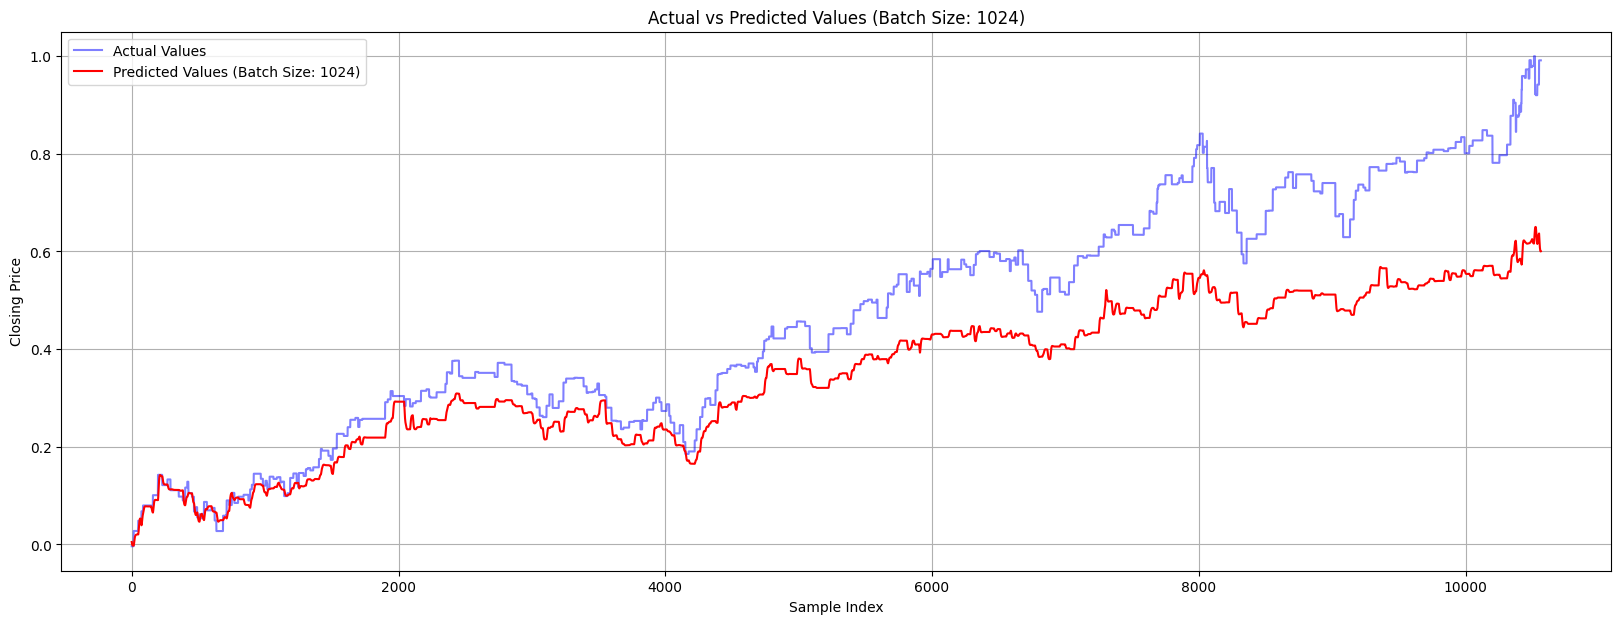

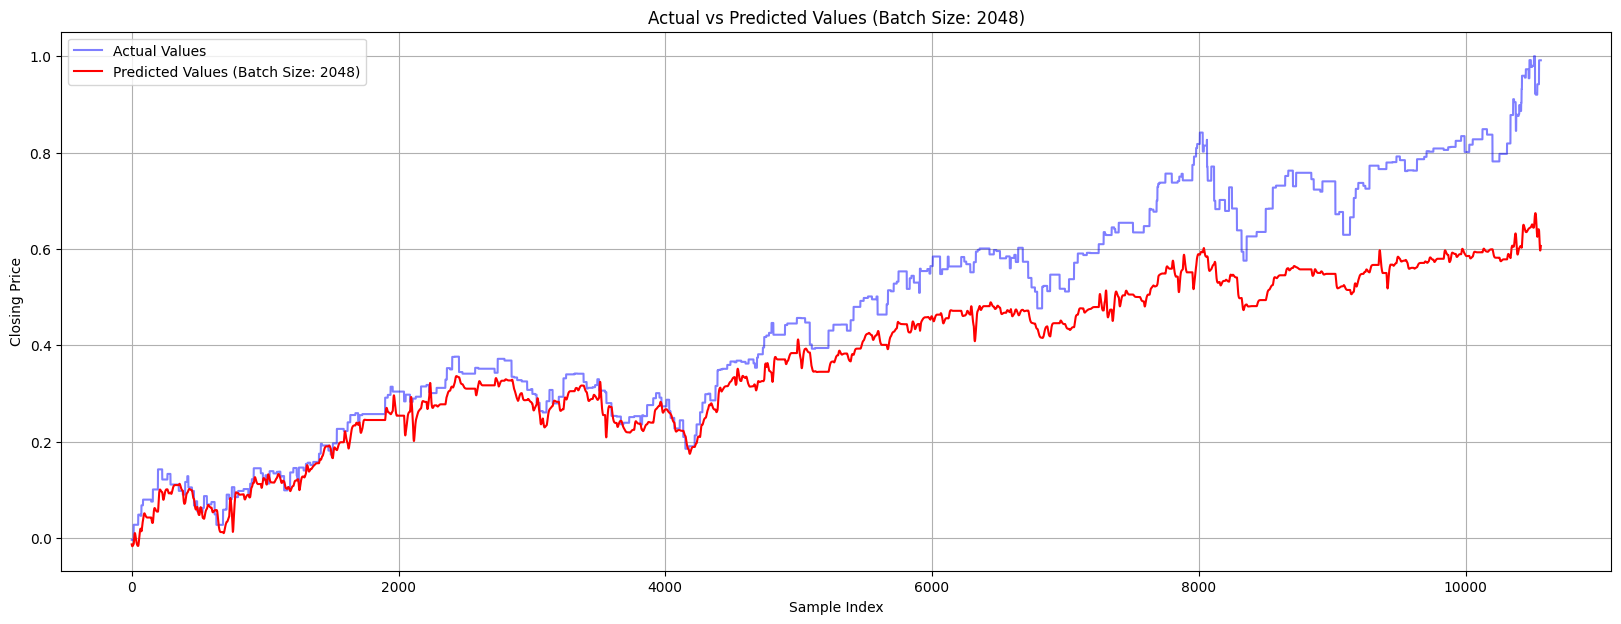

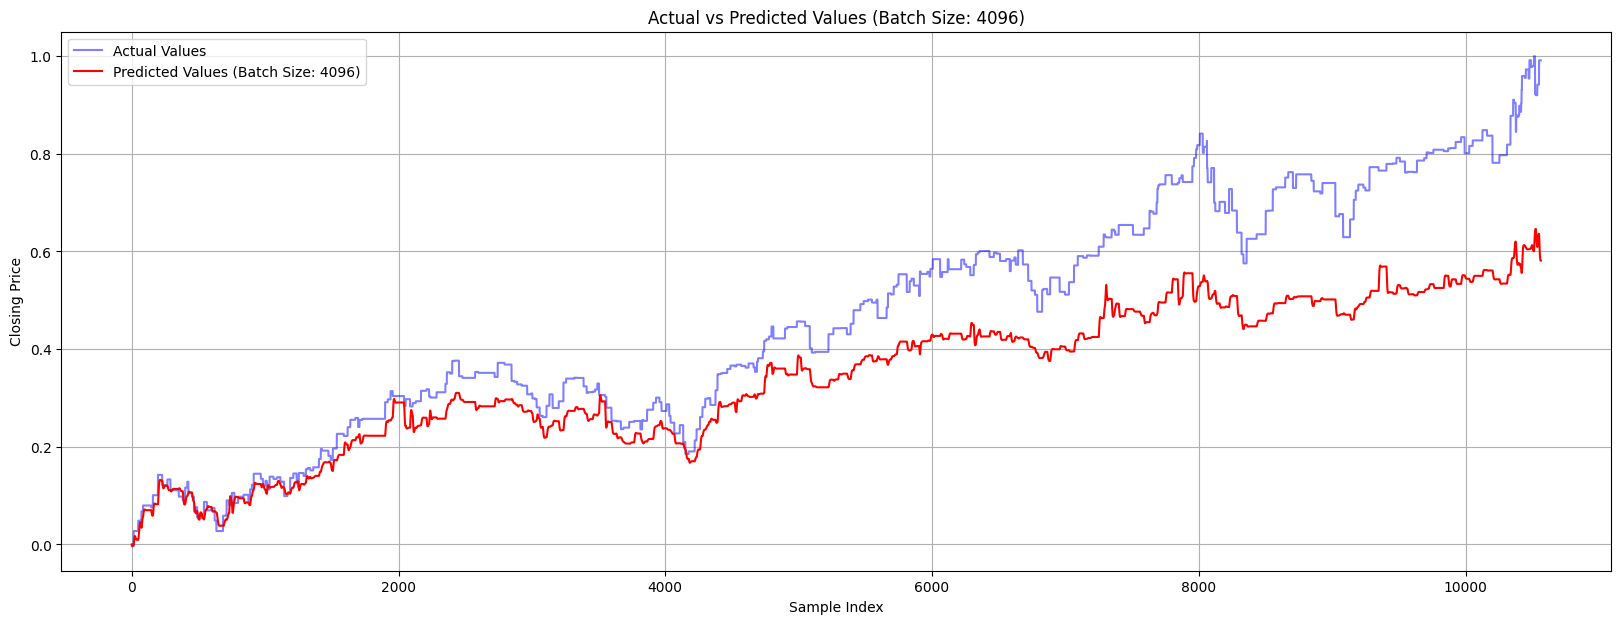

In [10]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

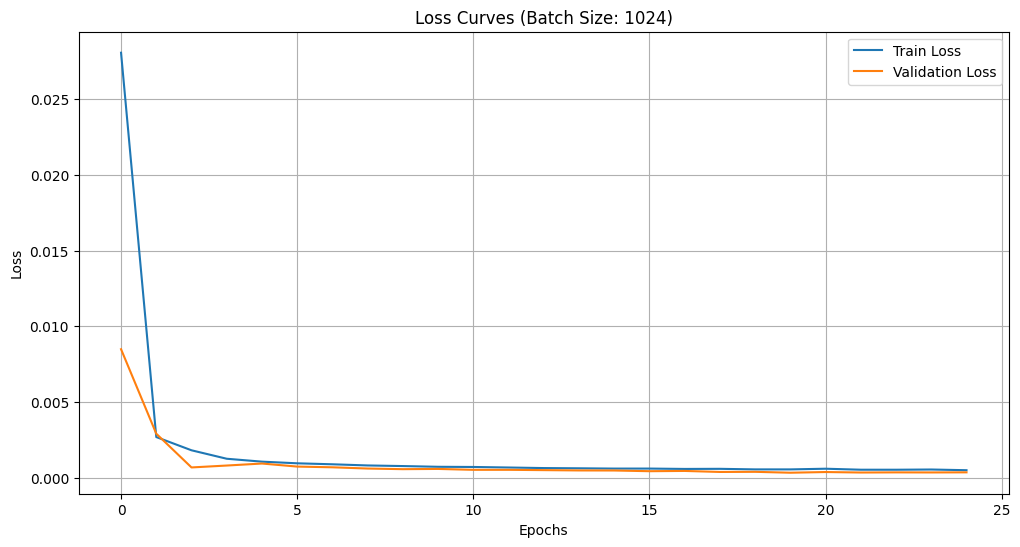

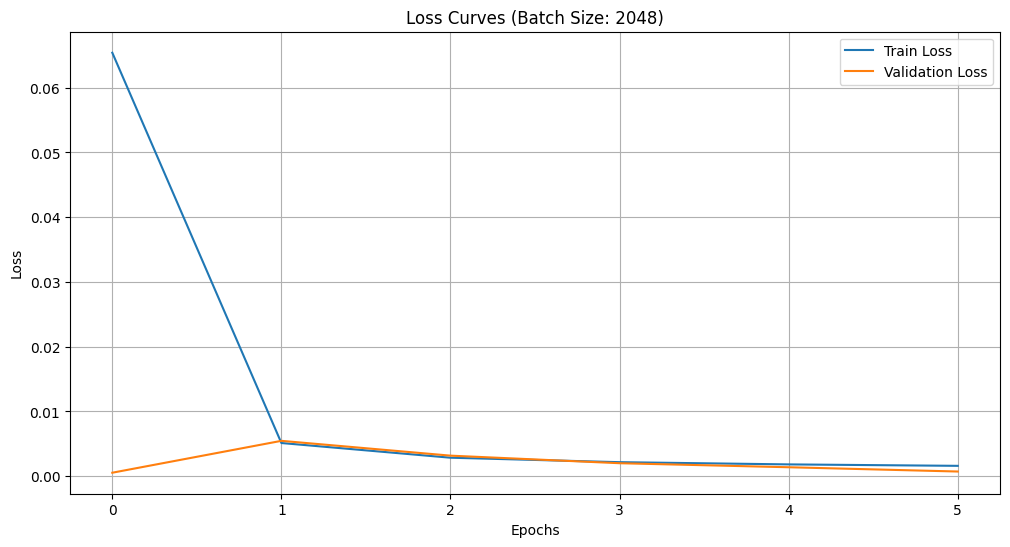

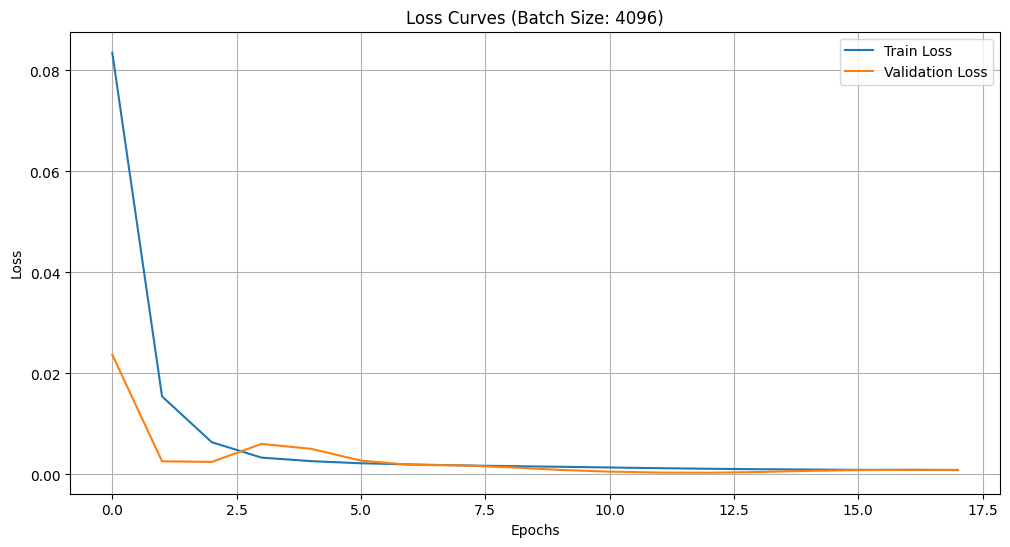

In [11]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [12]:
from sklearn.model_selection import train_test_split

past_nasdaq = ['Open', 'High', 'Low', 'Volume', 'past_day_close']

X, y = create_dataset(df[past_nasdaq].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [13]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Batch Size: 1024, MSE: 0.030, RMSE: 0.175, R-squared: 0.458
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Batch Size: 2048, MSE: 0.008, RMSE: 0.088, R-squared: 0.862
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Batch Size: 4096, MSE: 0.008, RMSE: 0.090, R-squared: 0.856


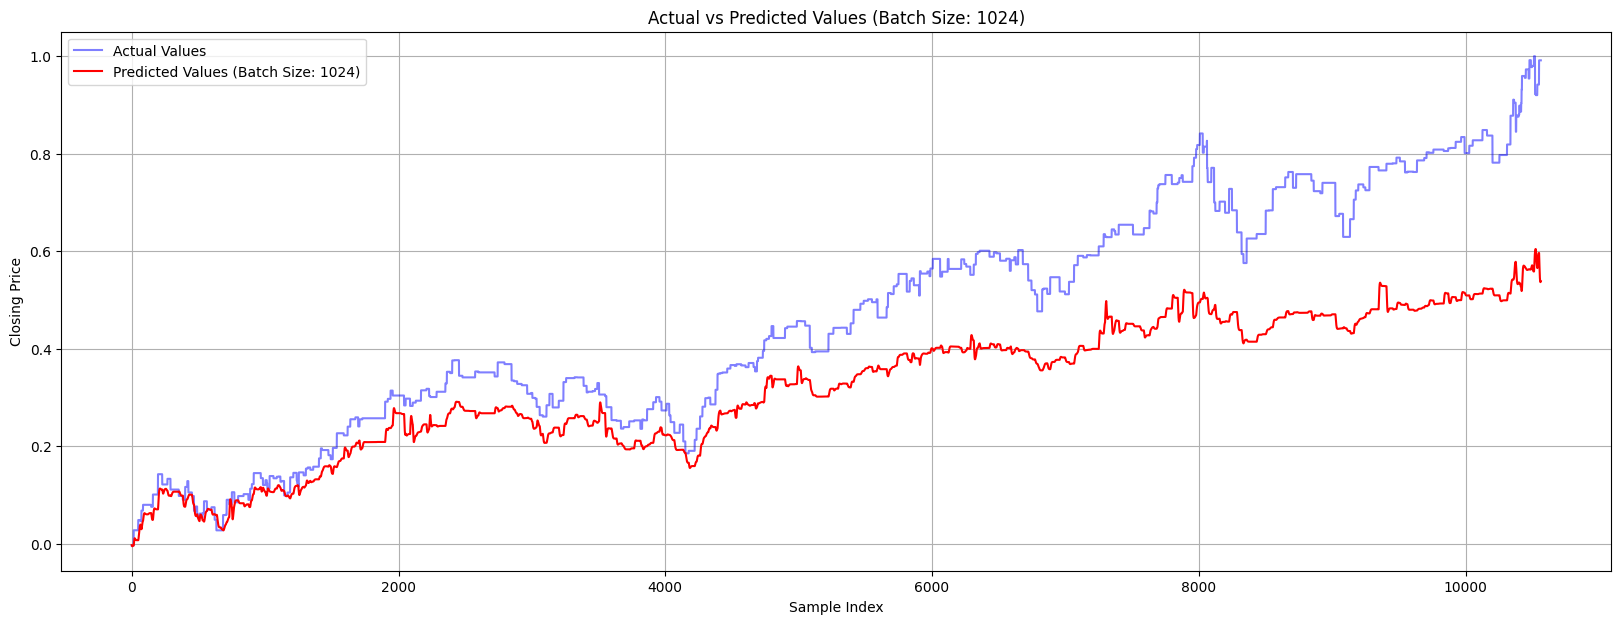

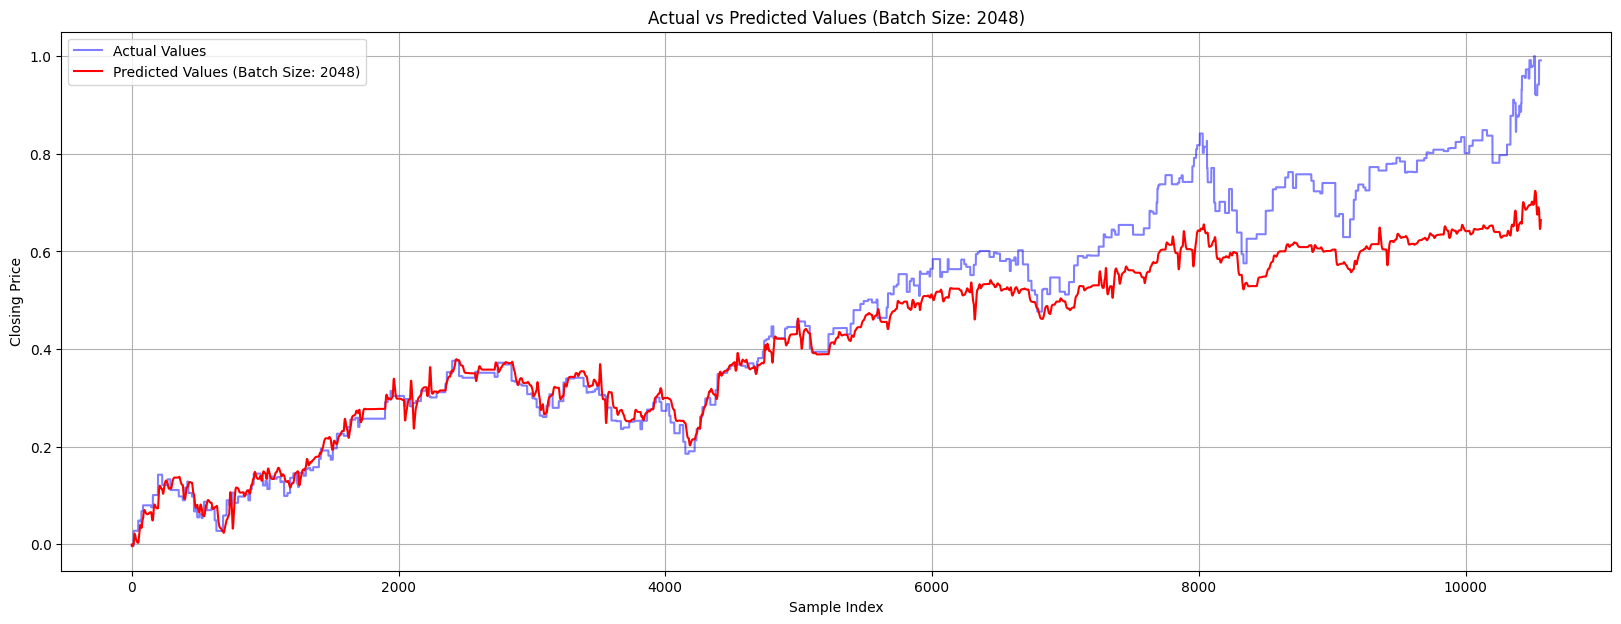

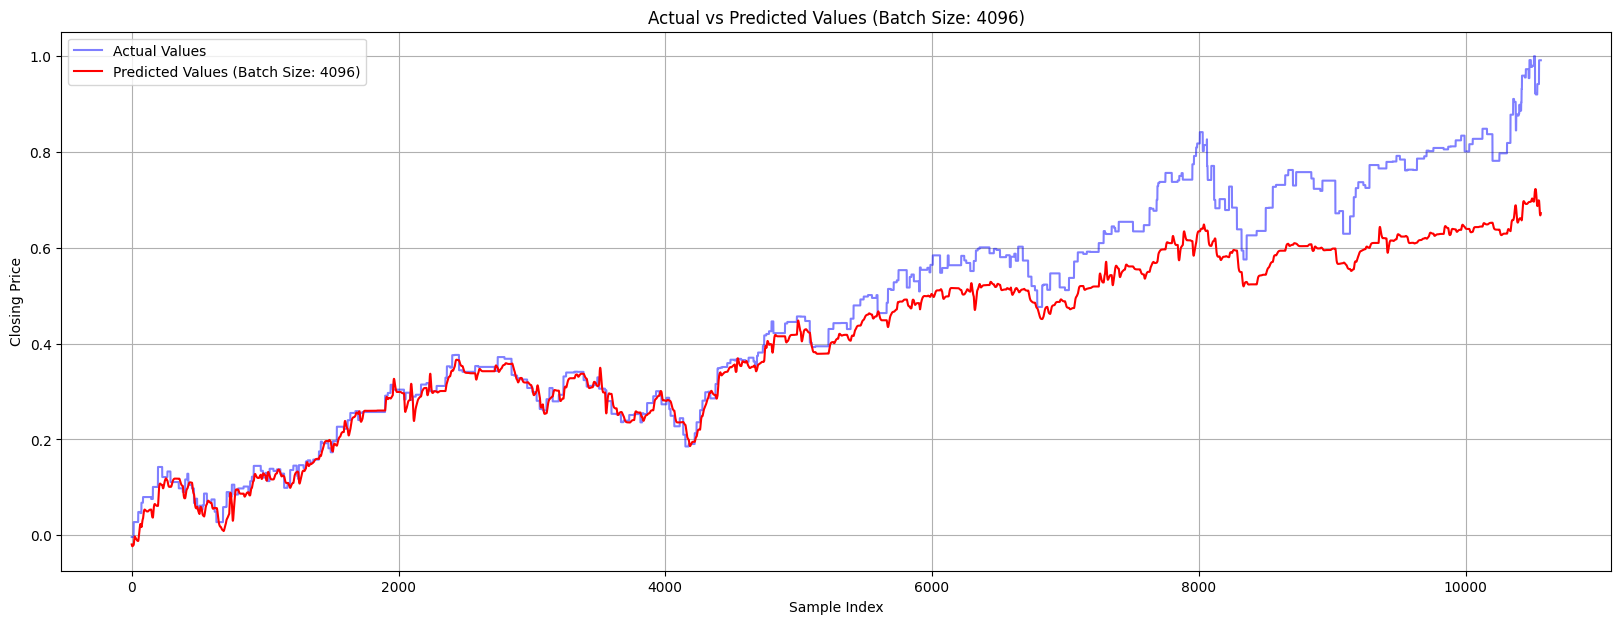

In [14]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

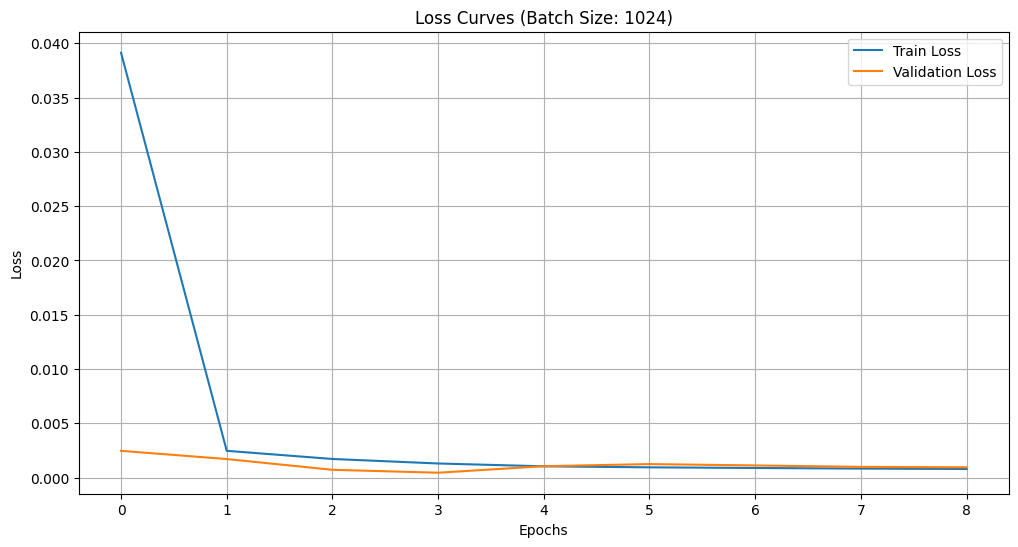

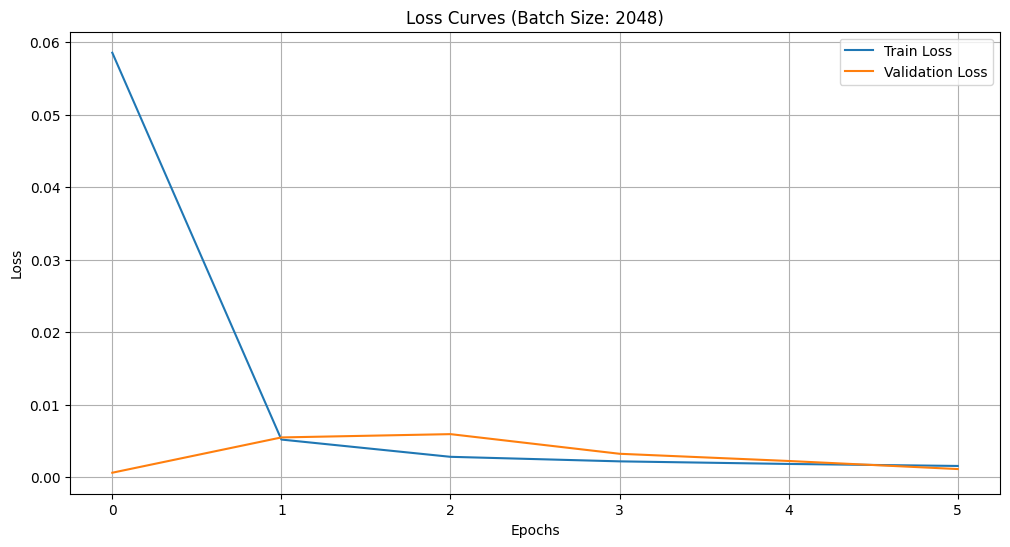

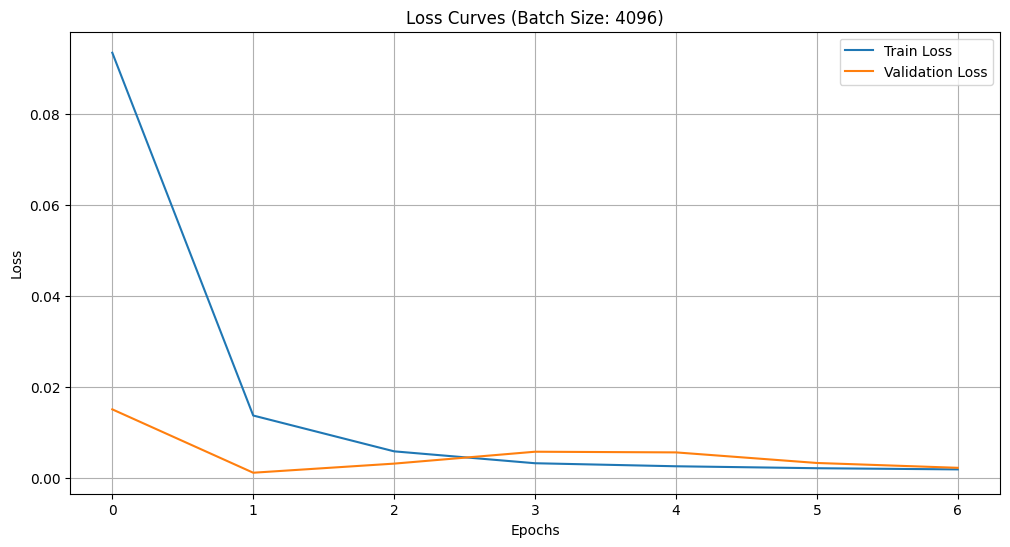

In [15]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [16]:
from sklearn.model_selection import train_test_split

past_nasdaq_vader = ['Open', 'High', 'Low', 'Volume', 'past_day_close', 'vader_sentiment']

X, y = create_dataset(df[past_nasdaq_vader].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [17]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Batch Size: 1024, MSE: 0.019, RMSE: 0.139, R-squared: 0.659
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Batch Size: 2048, MSE: 0.026, RMSE: 0.161, R-squared: 0.537
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Batch Size: 4096, MSE: 0.014, RMSE: 0.118, R-squared: 0.753


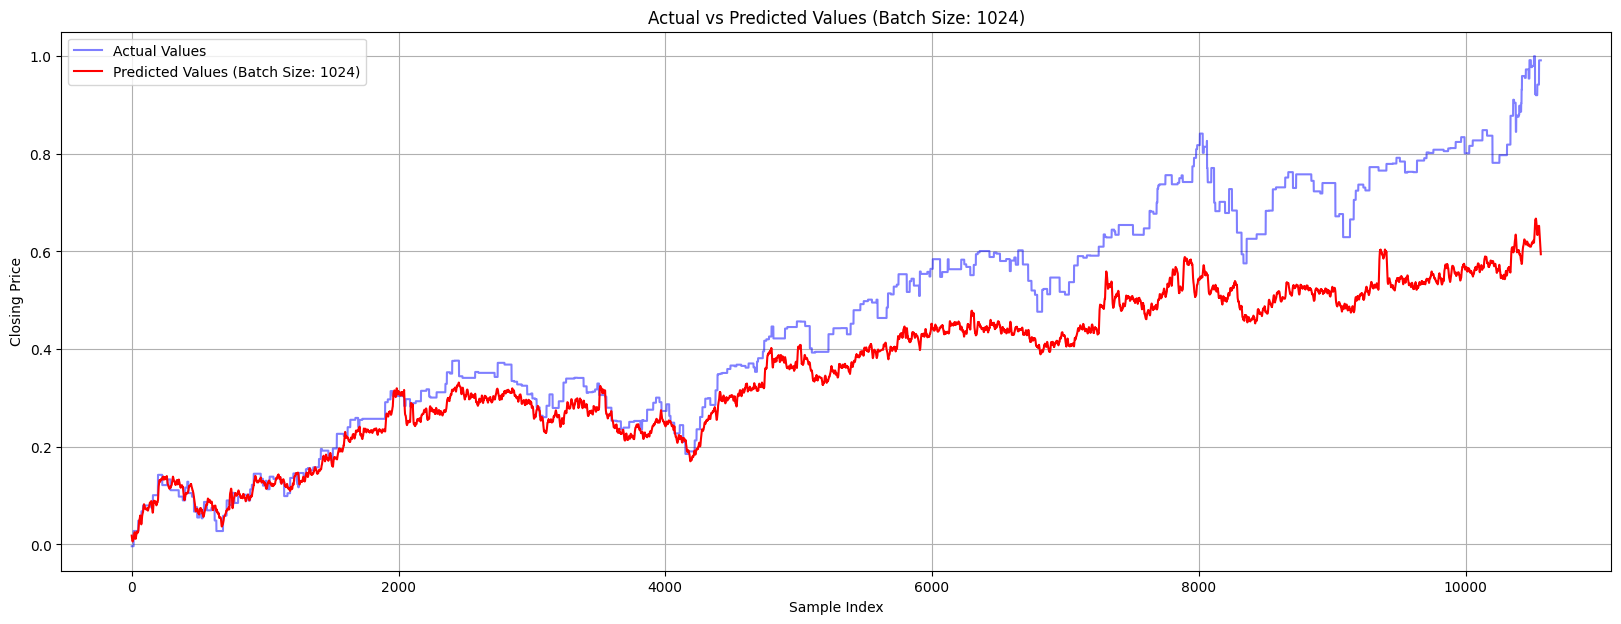

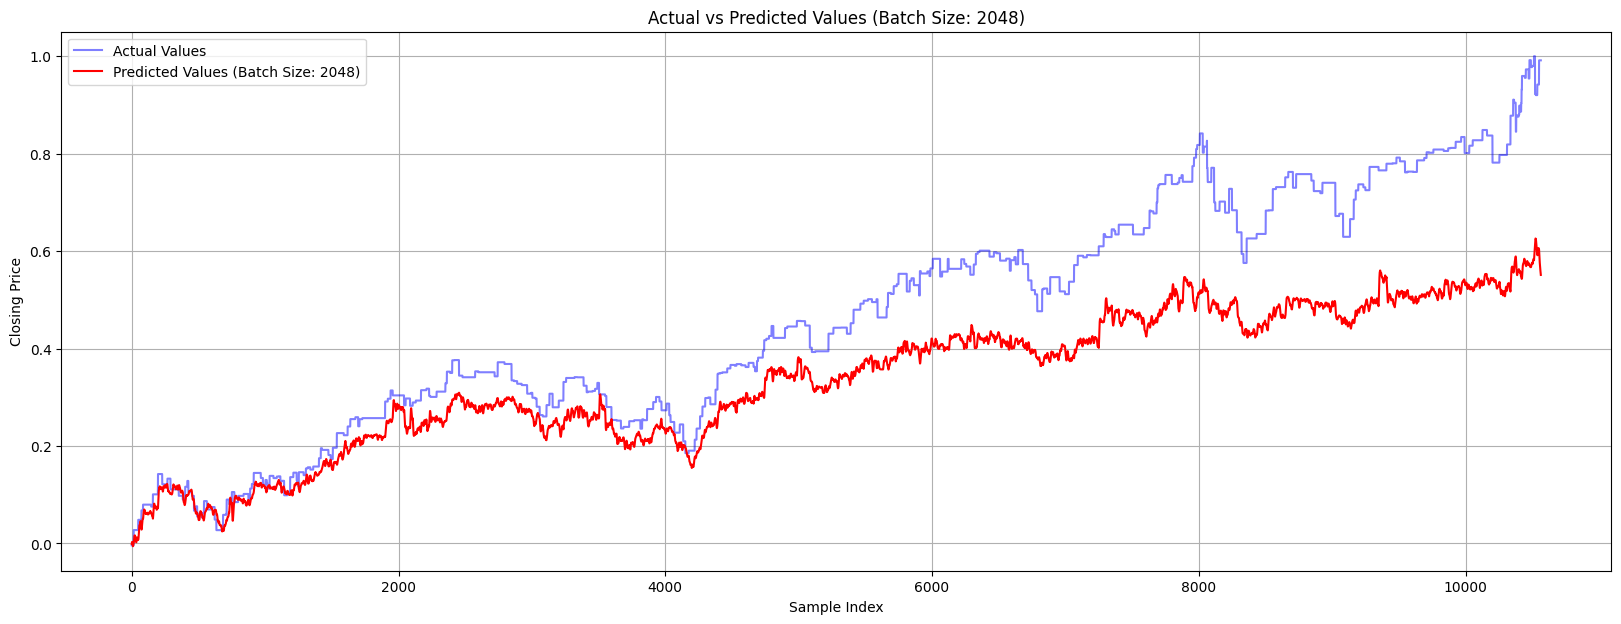

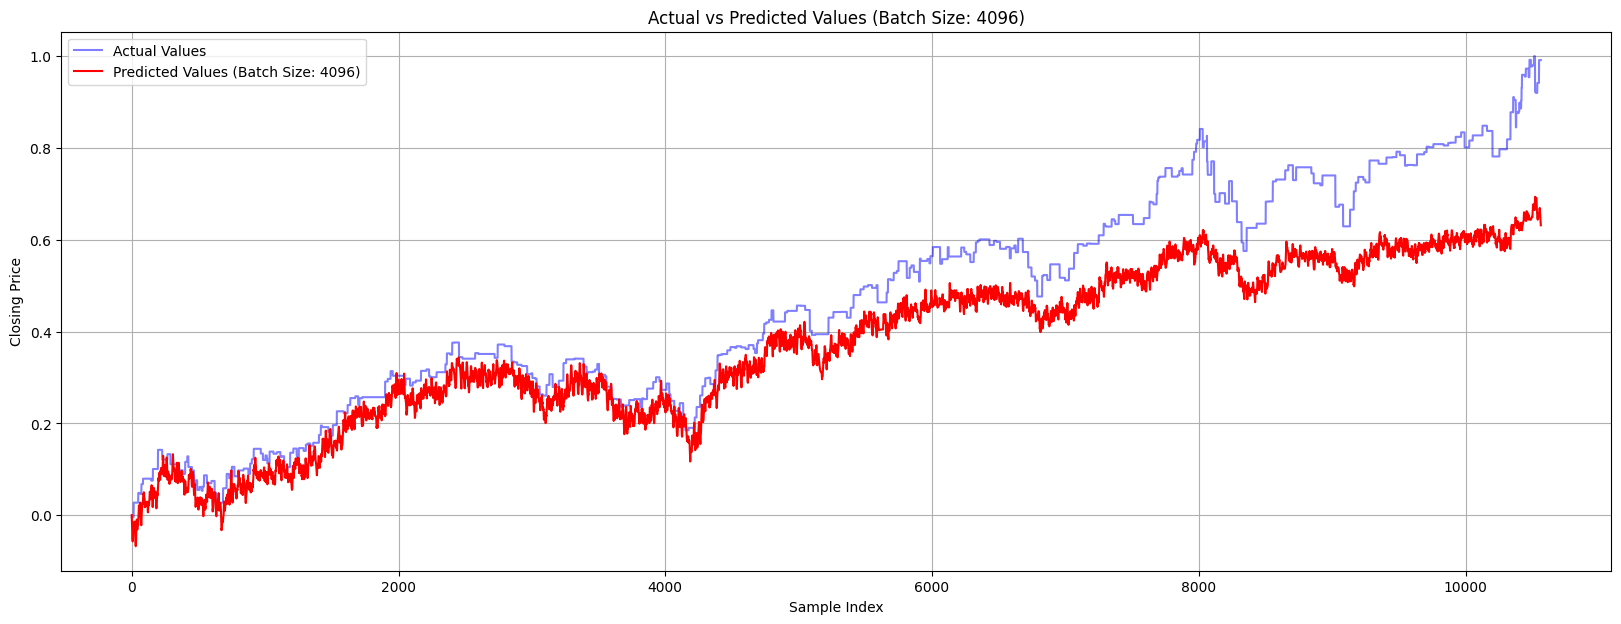

In [18]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

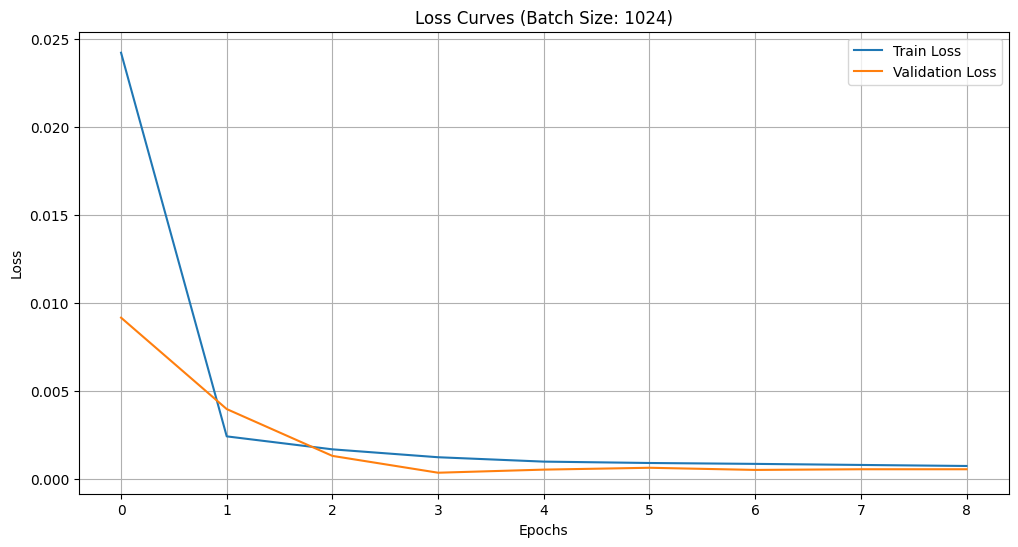

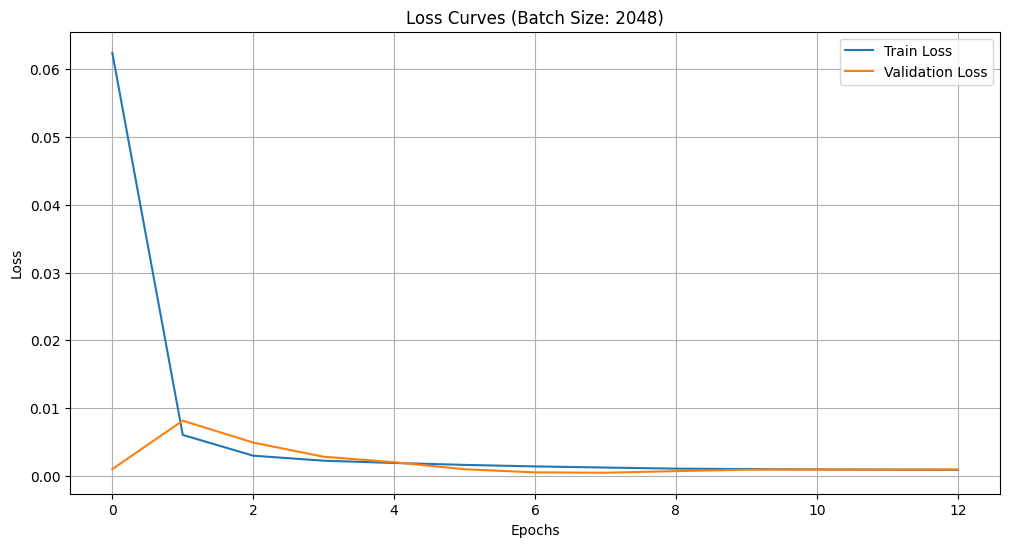

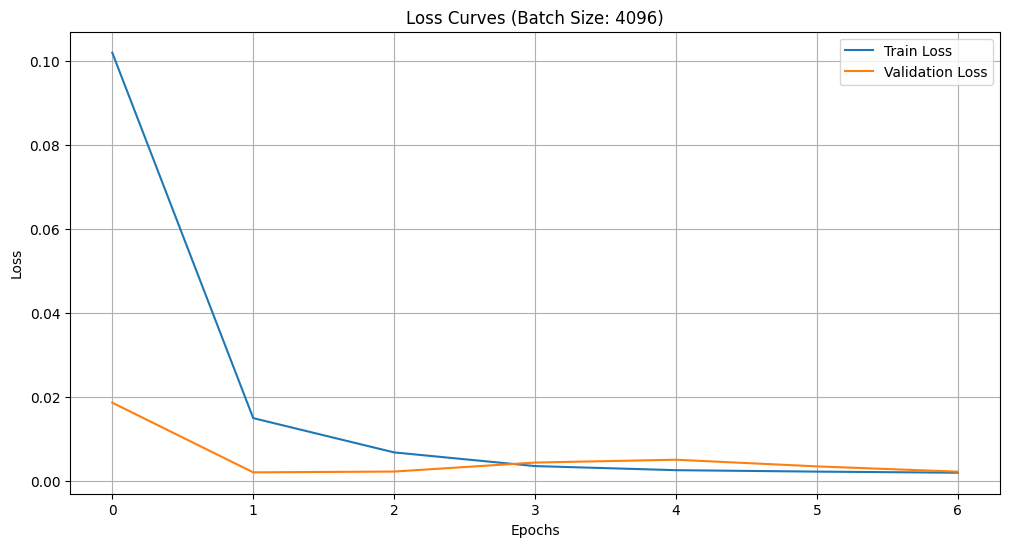

In [19]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [20]:
from sklearn.model_selection import train_test_split

past_nasdaq_roberta = ['Open', 'High', 'Low', 'Volume', 'past_day_close', 'roberta_sentiment']

X, y = create_dataset(df[past_nasdaq].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [21]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Batch Size: 1024, MSE: 0.028, RMSE: 0.167, R-squared: 0.506
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
Batch Size: 2048, MSE: 0.022, RMSE: 0.148, R-squared: 0.612
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
Batch Size: 4096, MSE: 0.017, RMSE: 0.132, R-squared: 0.689


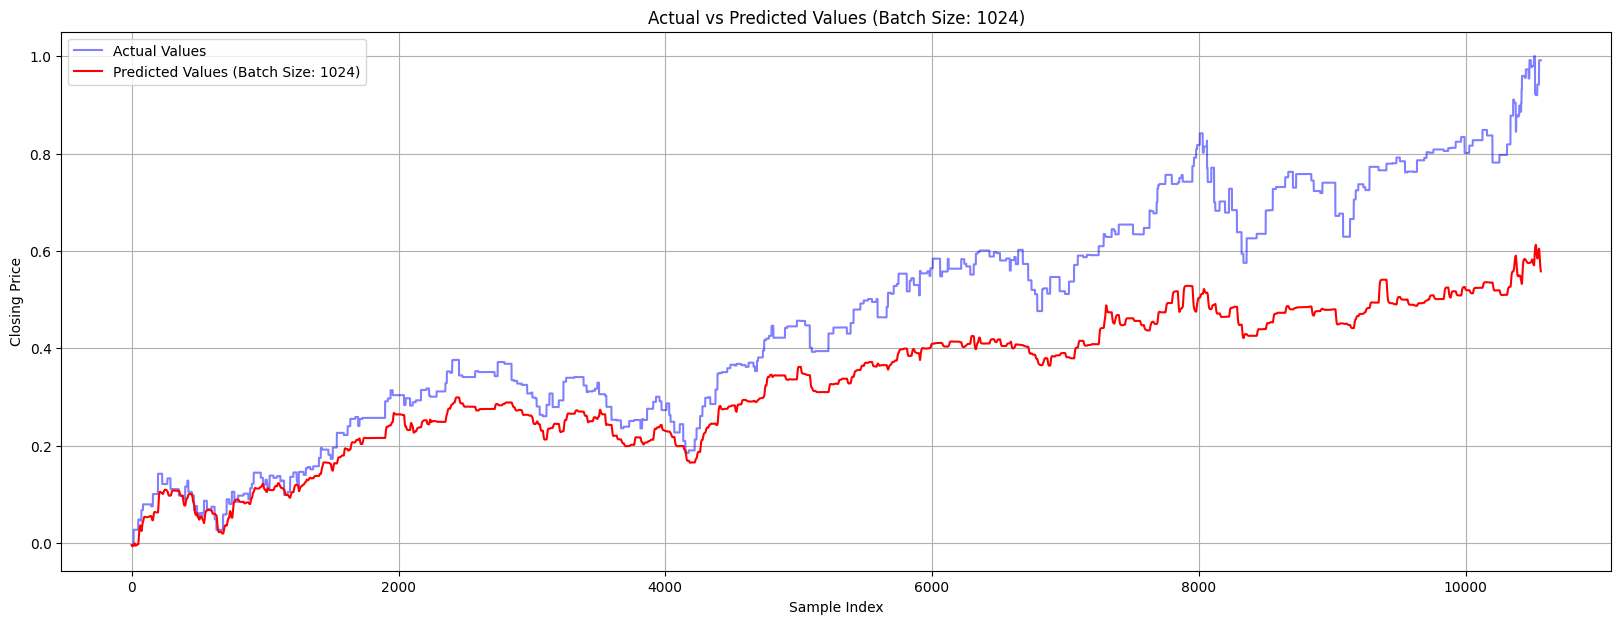

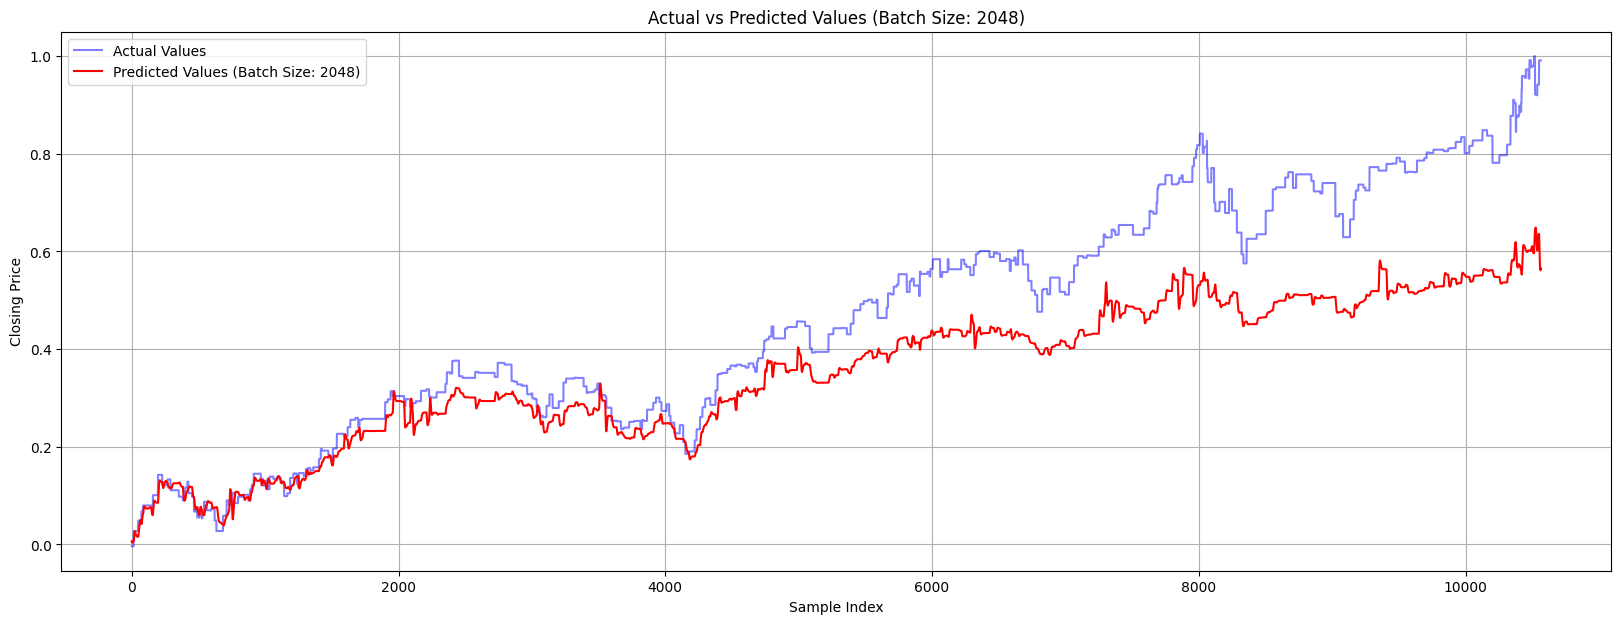

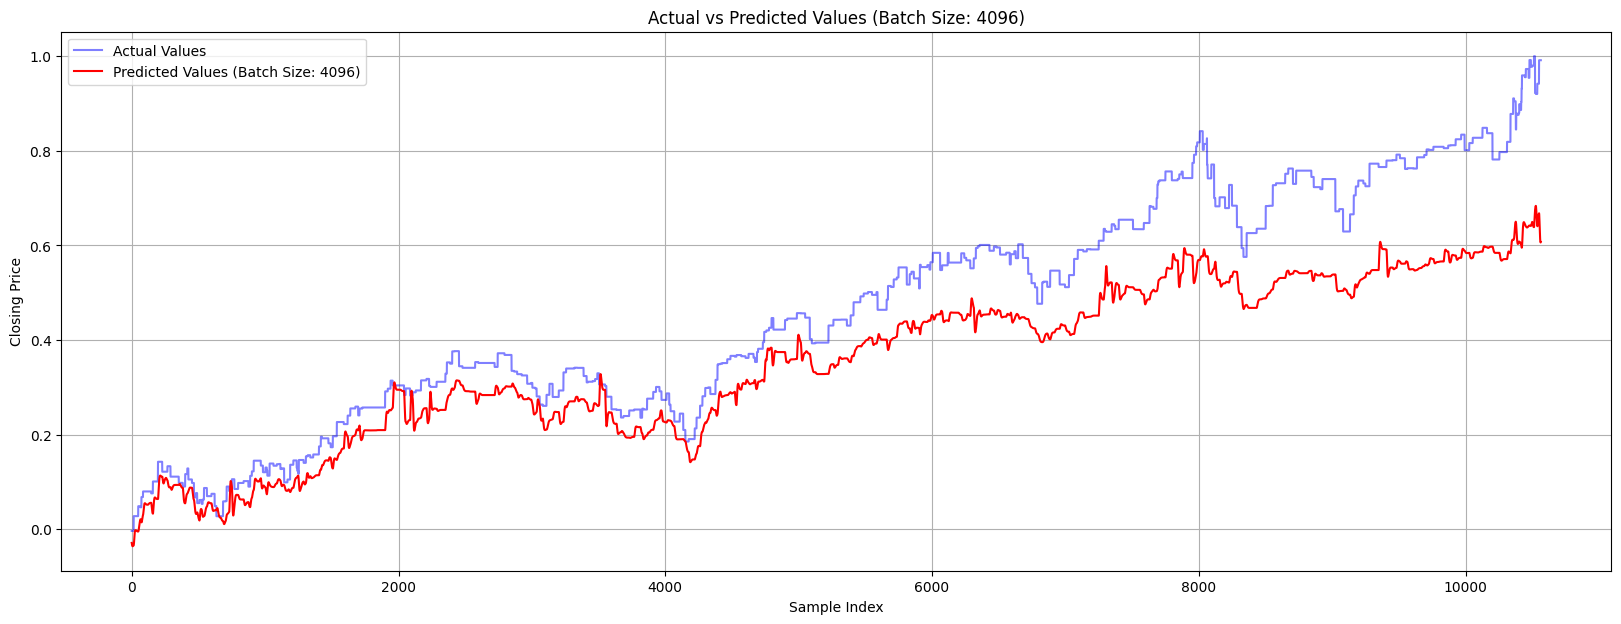

In [22]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

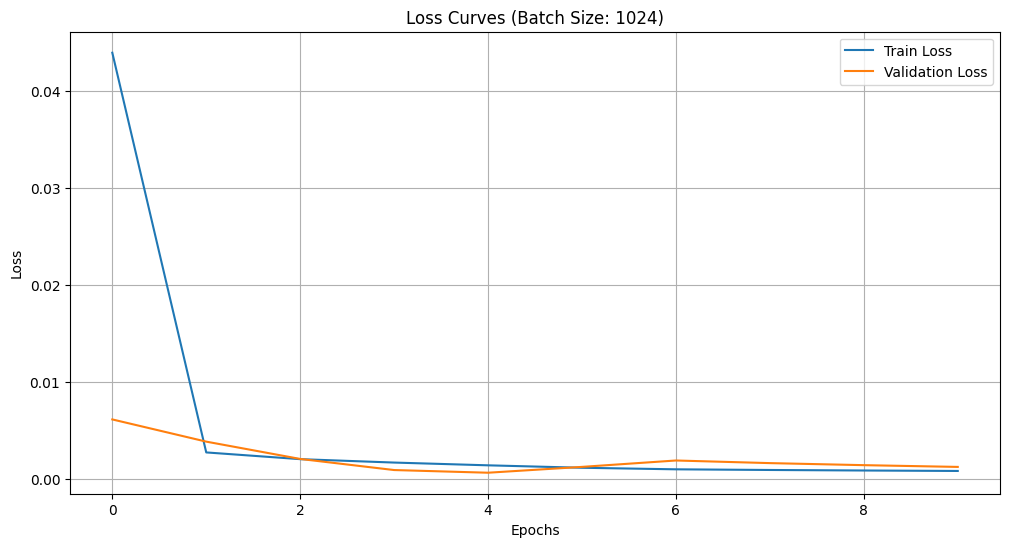

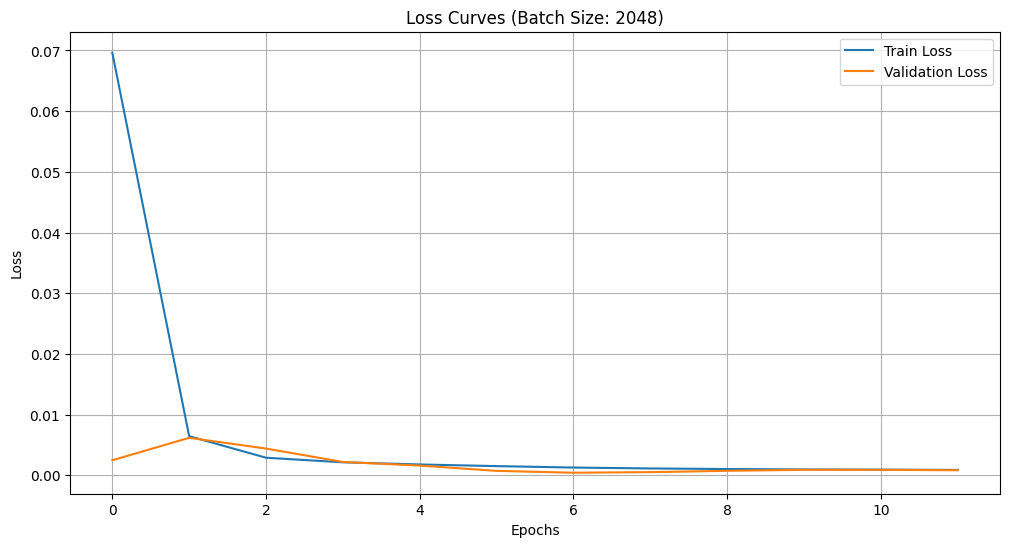

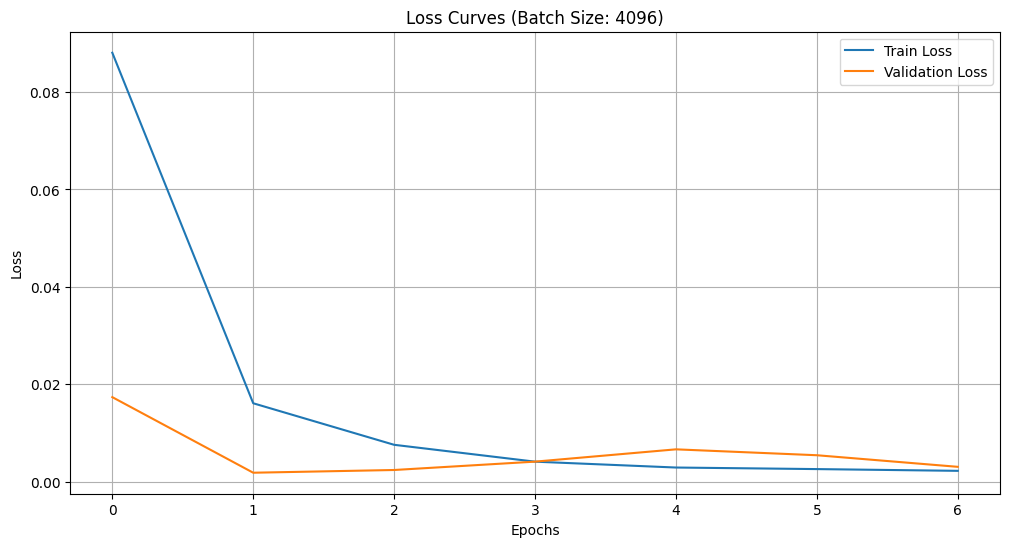

In [23]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [24]:
from sklearn.model_selection import train_test_split

past_nasdaq_sentiment = ['Open', 'High', 'Low', 'Volume', 'past_day_close', 'vader_sentiment', 'roberta_sentiment']

X, y = create_dataset(df[past_nasdaq_sentiment].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [25]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Batch Size: 1024, MSE: 0.033, RMSE: 0.181, R-squared: 0.416
331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
Batch Size: 2048, MSE: 0.032, RMSE: 0.179, R-squared: 0.433
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Batch Size: 4096, MSE: 0.005, RMSE: 0.070, R-squared: 0.912


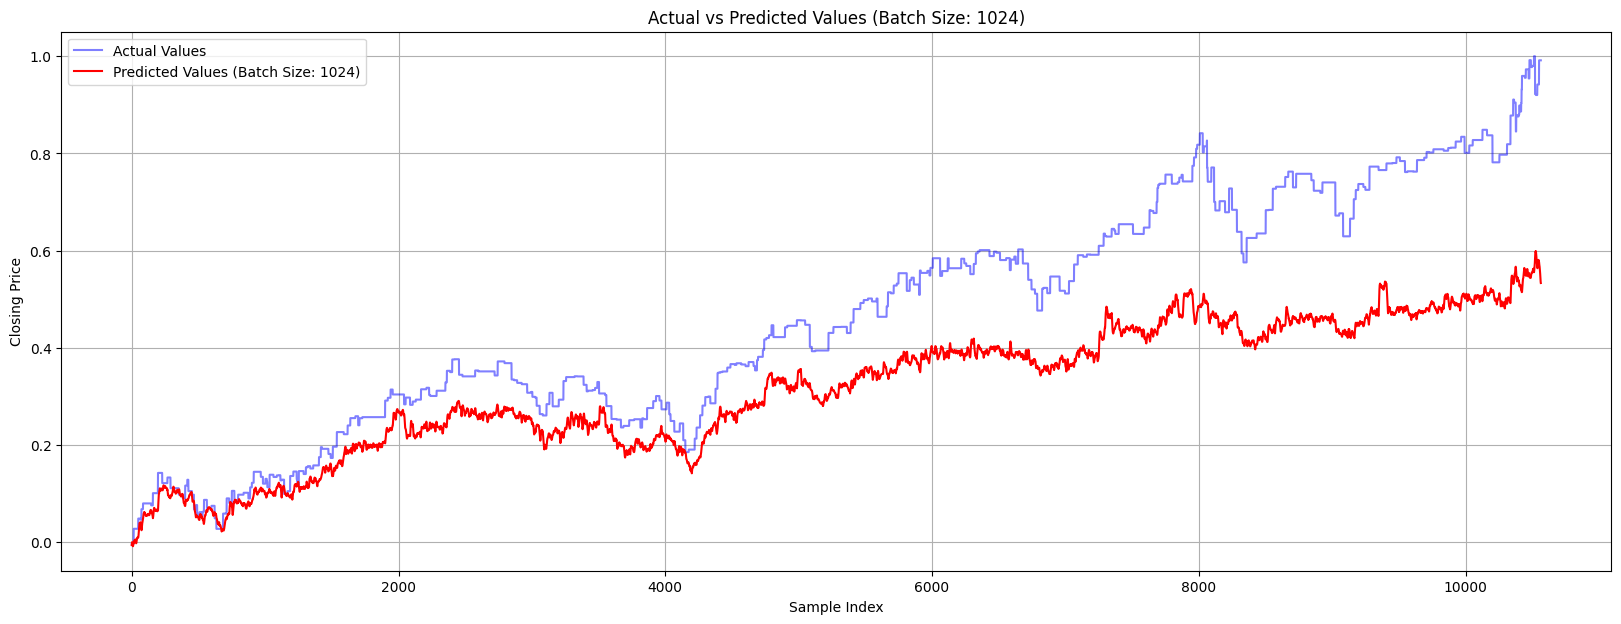

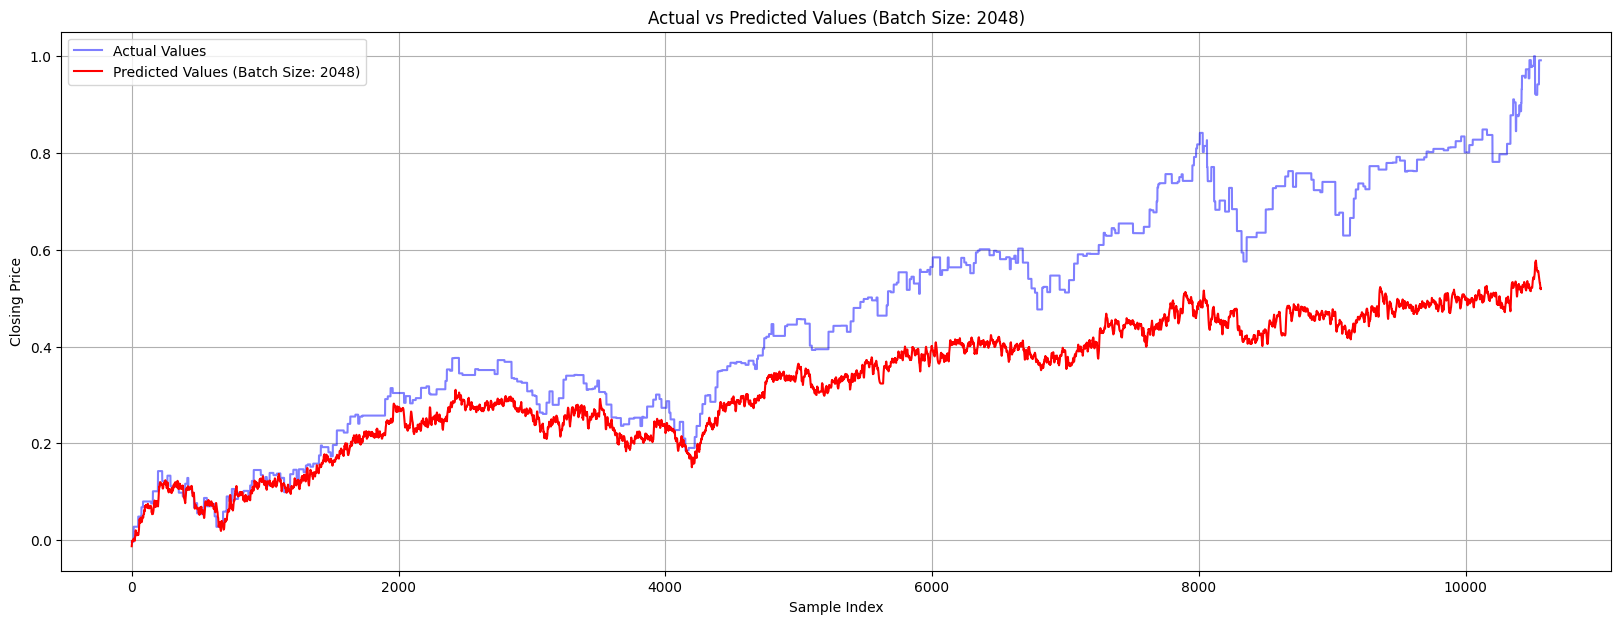

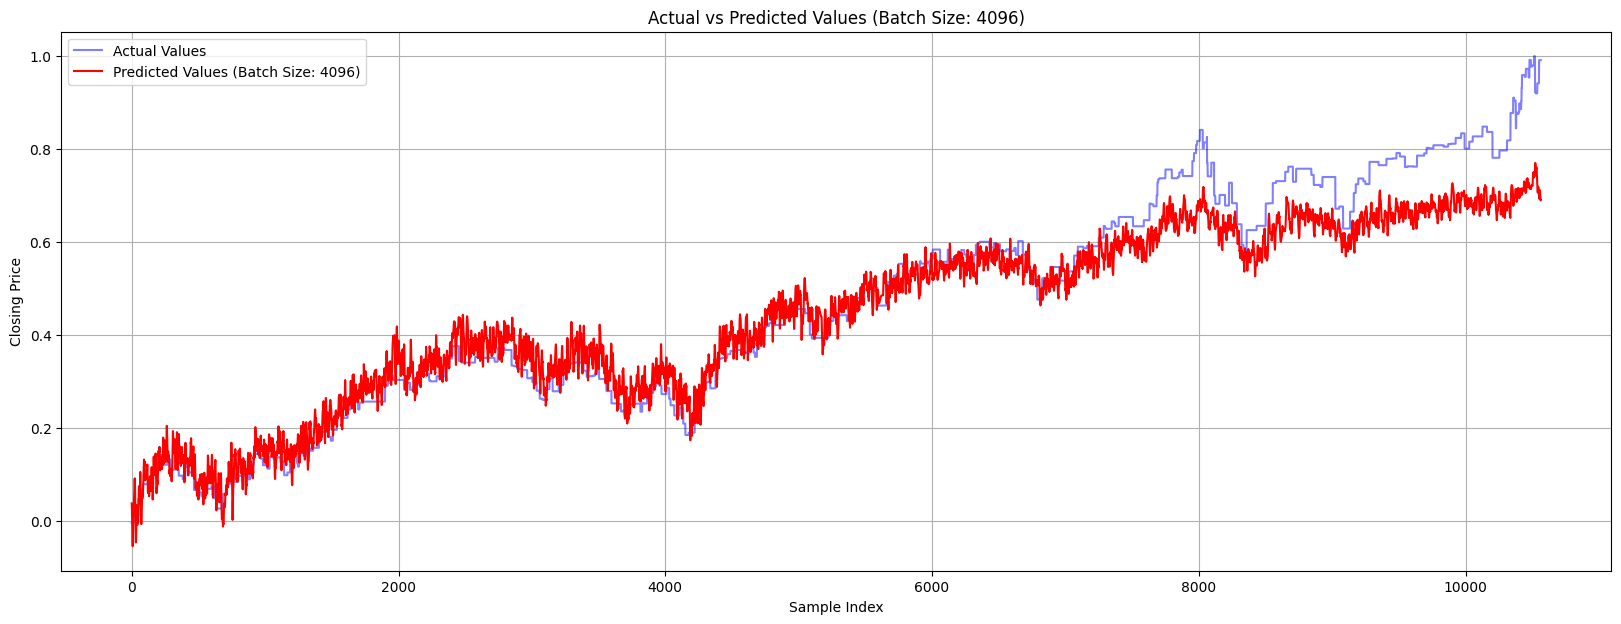

In [26]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

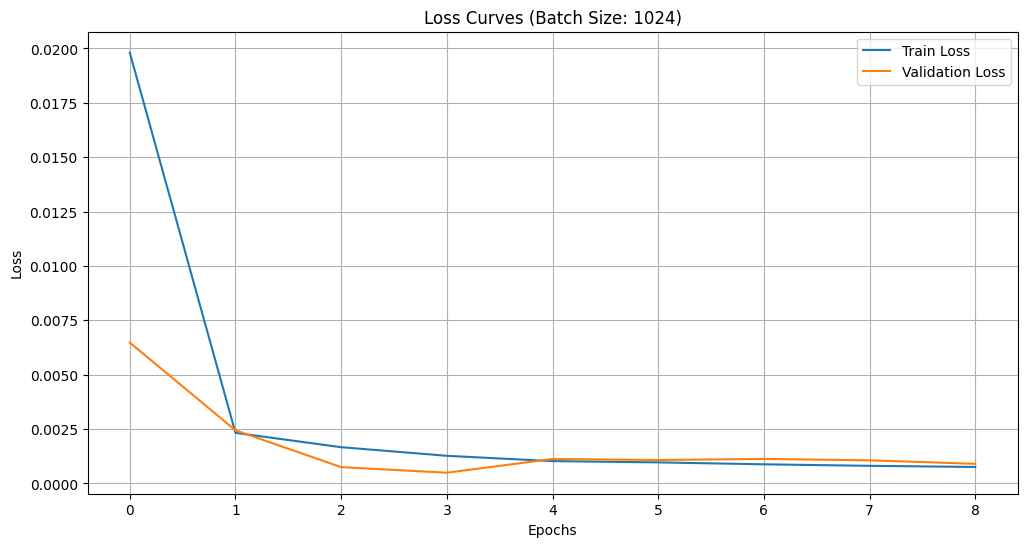

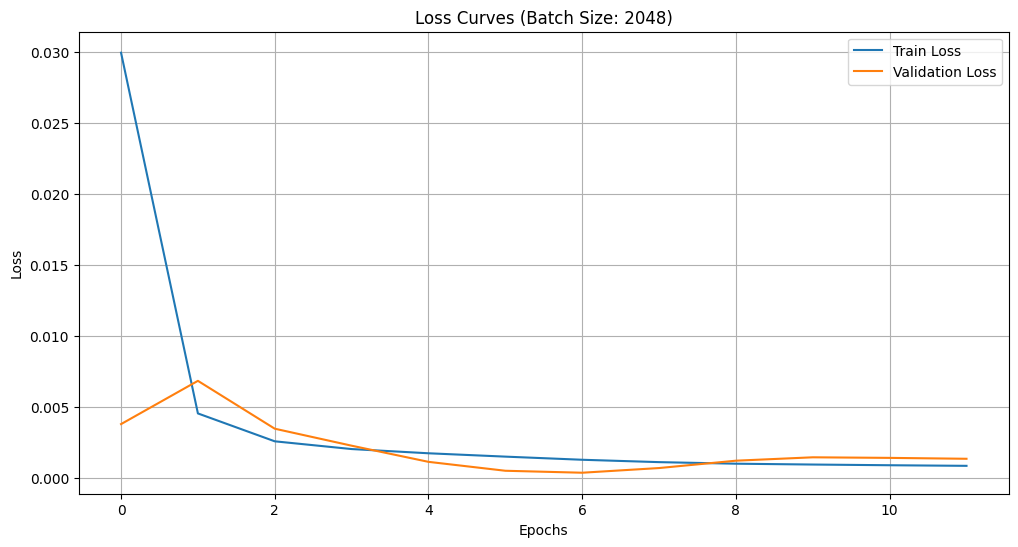

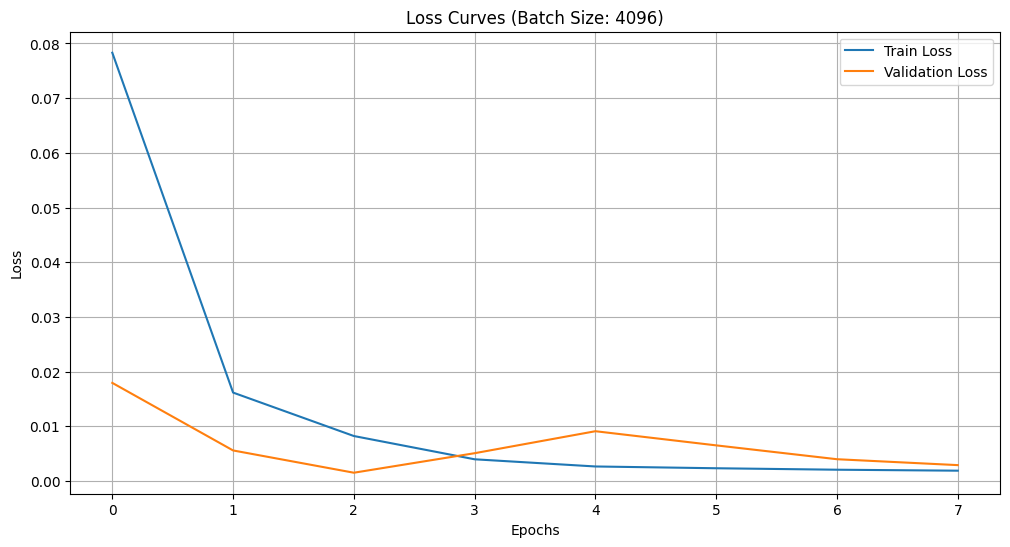

In [27]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [28]:
from sklearn.model_selection import train_test_split

nasdaq_sentiment = ['Open', 'High', 'Low', 'Volume', 'vader_sentiment', 'roberta_sentiment']

X, y = create_dataset(df[nasdaq_sentiment].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [29]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Batch Size: 1024, MSE: 0.024, RMSE: 0.154, R-squared: 0.578
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
Batch Size: 2048, MSE: 0.022, RMSE: 0.148, R-squared: 0.609
331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
Batch Size: 4096, MSE: 0.007, RMSE: 0.082, R-squared: 0.879


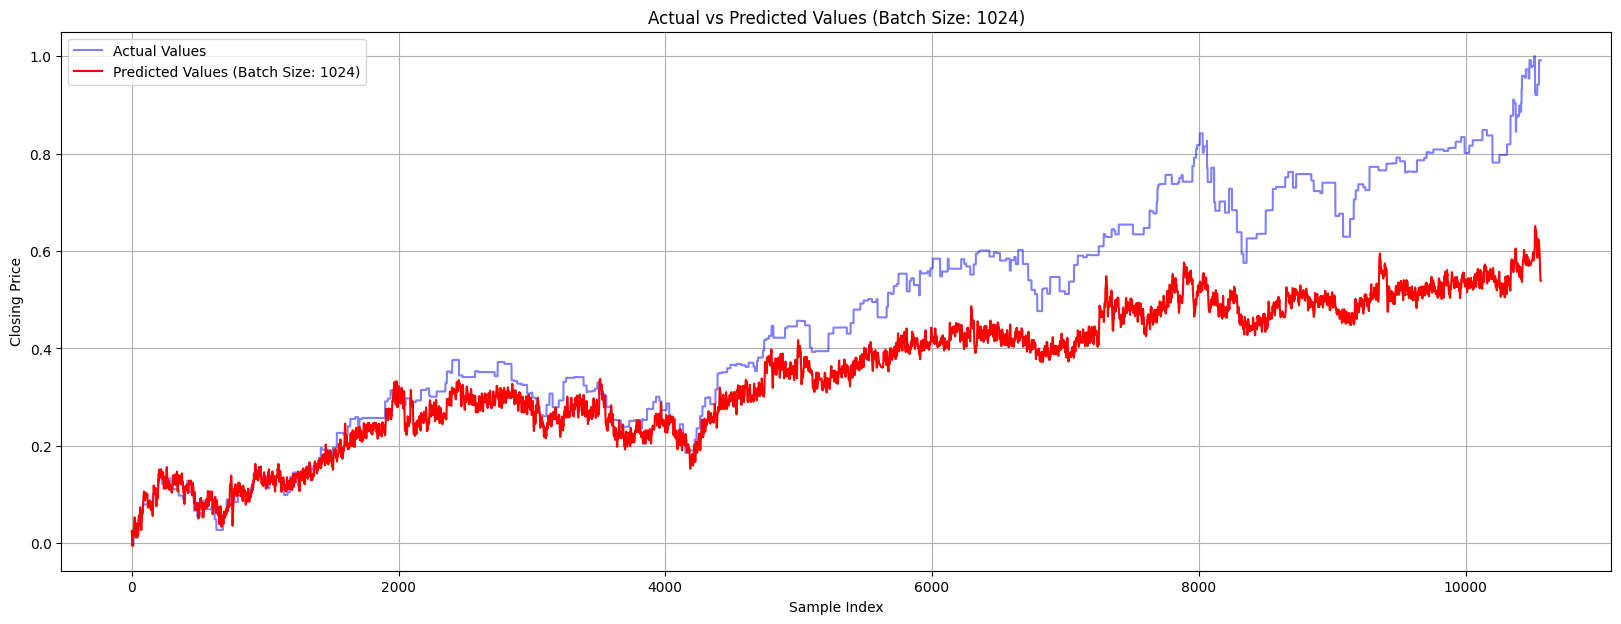

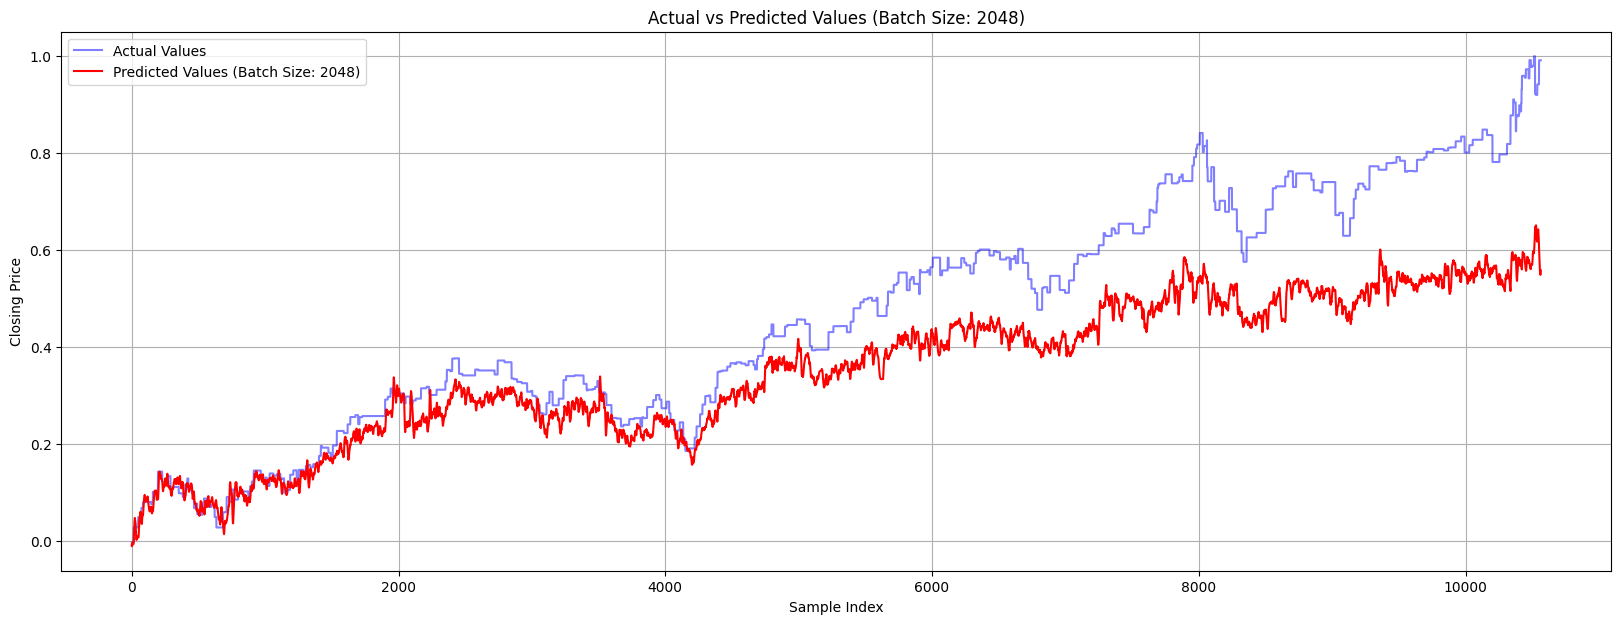

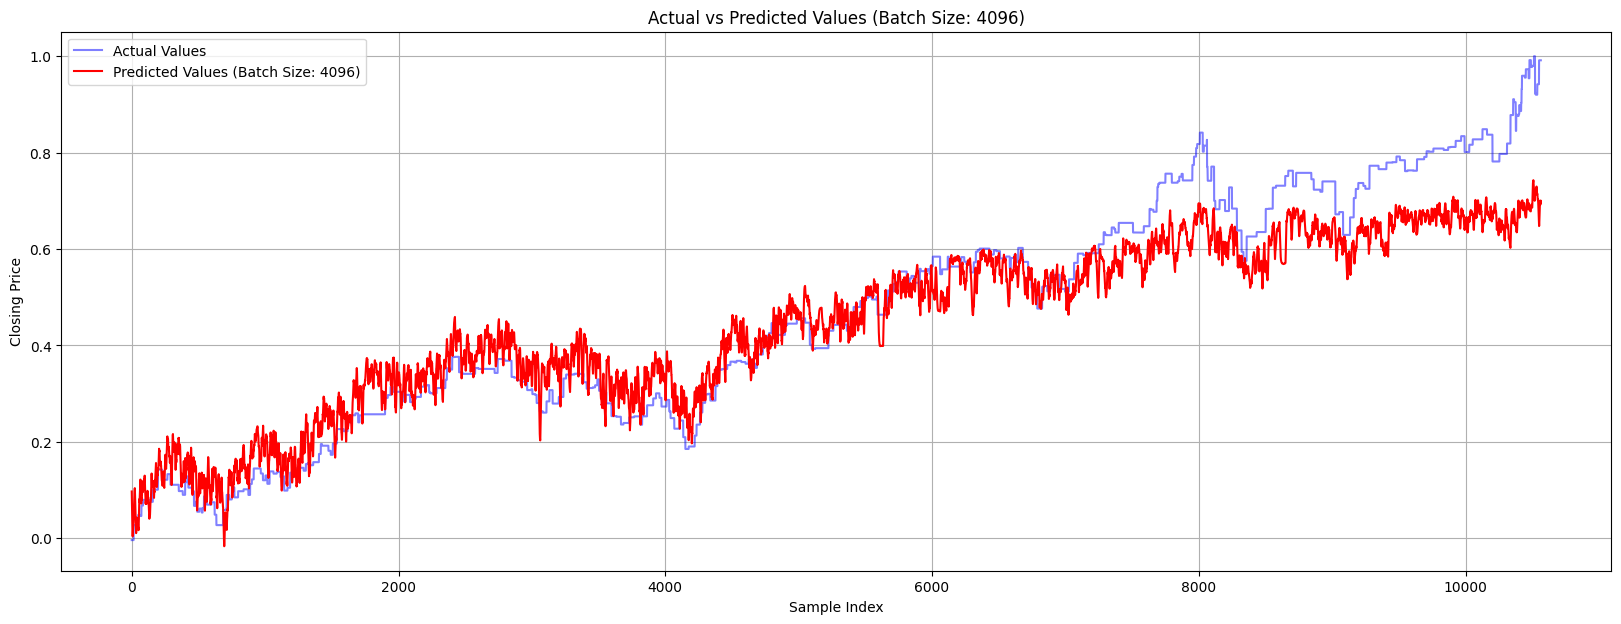

In [30]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

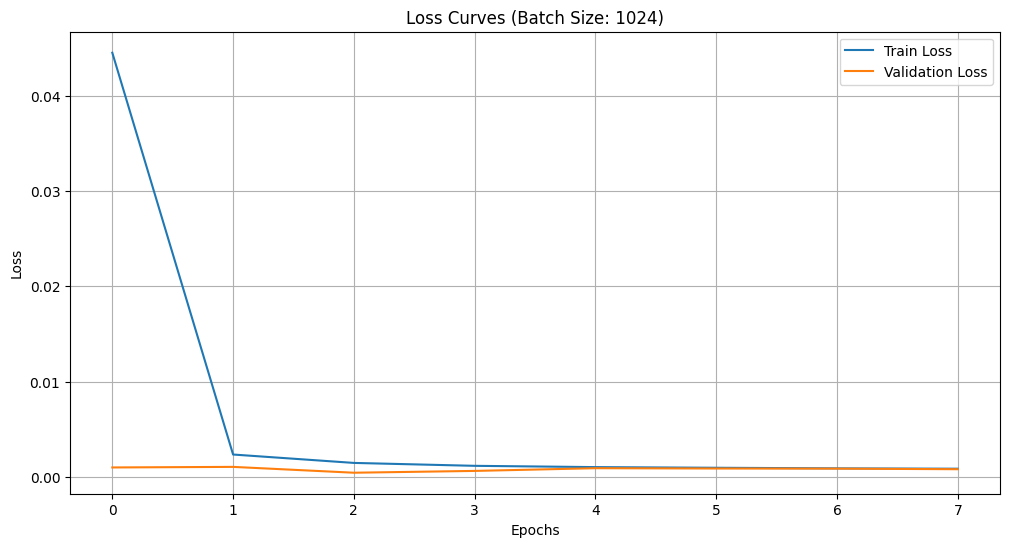

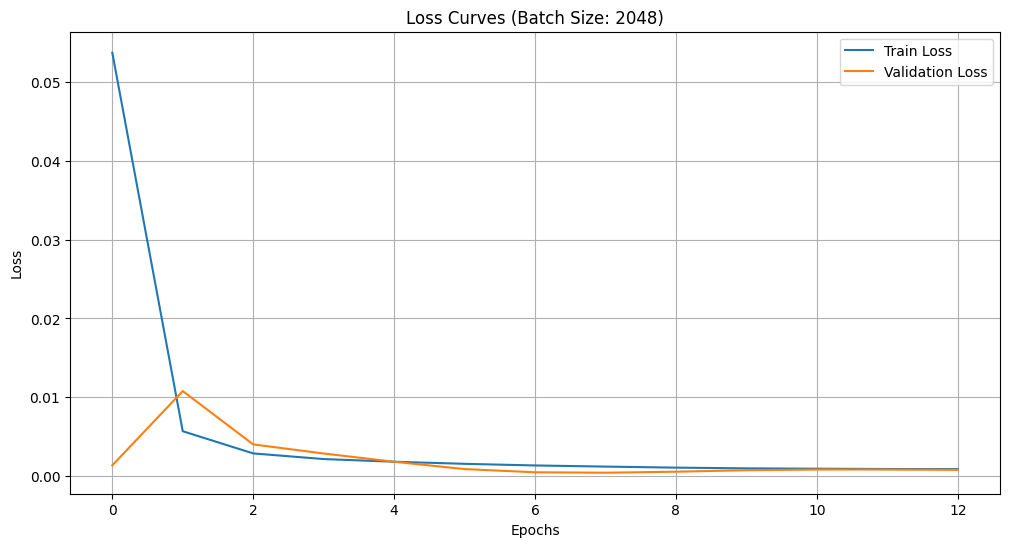

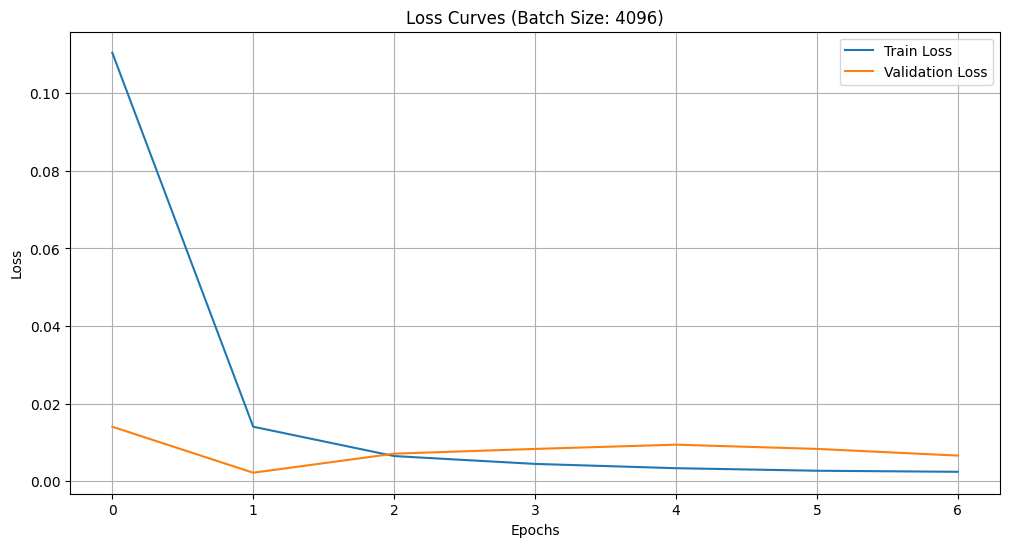

In [31]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [32]:
from sklearn.model_selection import train_test_split

past_nasdaq = ['Open', 'High', 'Low', 'Volume', 'past_day_close']

X, y = create_dataset(df[past_nasdaq].values, df['Adj Close'].values)

# 데이터셋을 train+validation, test 나누기 (8:2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# train, validation (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, shuffle = False)

In [33]:
# 다양한 배치 크기로 모델 학습
batch_sizes = [1024, 2048, 4096]
predictions_dict = {}  # 예측값 저장
history_dict = {}  # 손실 기록 저장

for batch_size in batch_sizes:
    model = create_model()
    history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # 손실 기록 저장
    history_dict[batch_size] = history.history

    # 예측 수행 및 평가
    mse, rmse, r_squared = evaluate_model(model, X_test, y_test)
    
    # 예측값 저장
    predictions_dict[batch_size] = model.predict(X_test).flatten()

    # 성능 출력
    print(f'Batch Size: {batch_size}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')
    # r_squared = 회귀 모델의 성능을 평가하는 데 사용되는 지표, 모델이 종속 변수의 변동성을 얼마나 잘 설명하는지 나타냄.
    # 일반적으로 0.7 이상이면 좋은 모델. 0과 1 사이의 값을 가짐!
    # 음수값이면 모델이 평균값 예측하는 것보다 더 나쁜 성능... 모델이 데이터에 적합하지 않음..

331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
Batch Size: 1024, MSE: 0.023, RMSE: 0.152, R-squared: 0.591
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Batch Size: 2048, MSE: 0.027, RMSE: 0.164, R-squared: 0.520
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Batch Size: 4096, MSE: 0.004, RMSE: 0.066, R-squared: 0.922


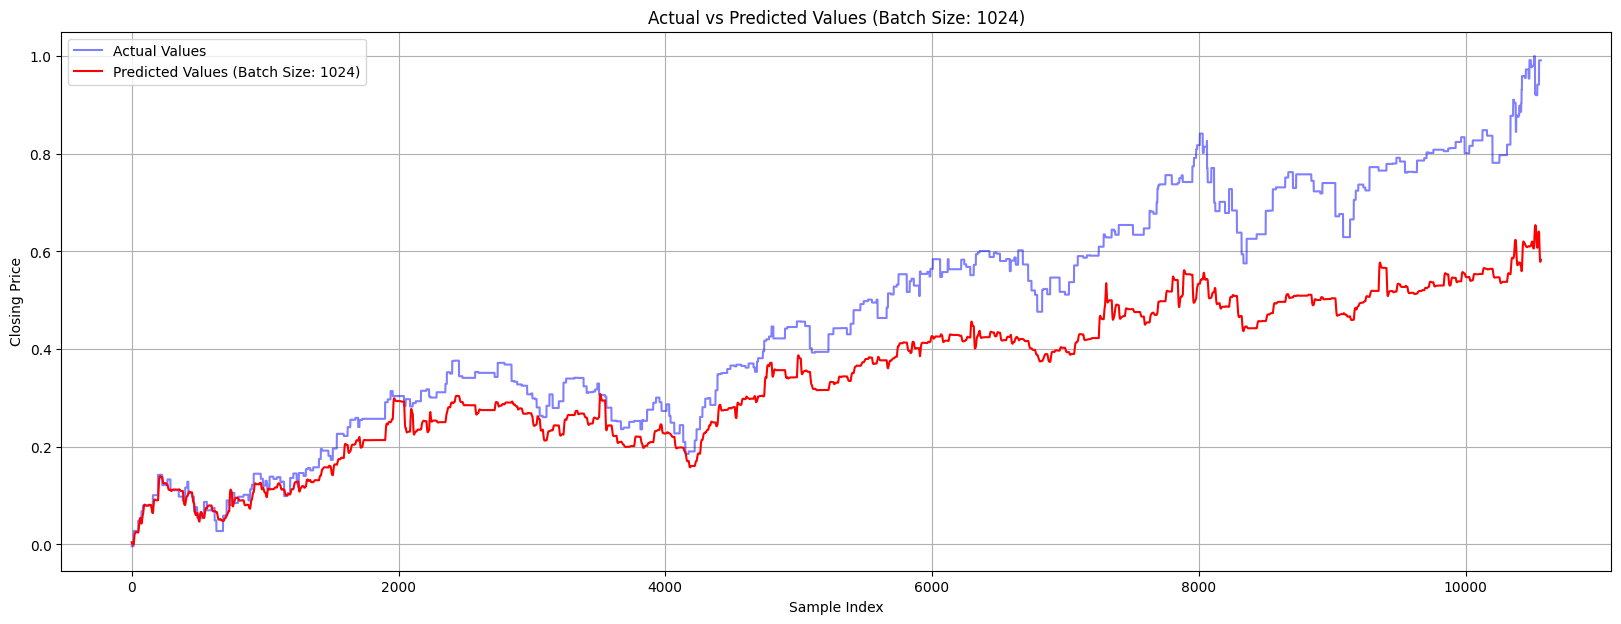

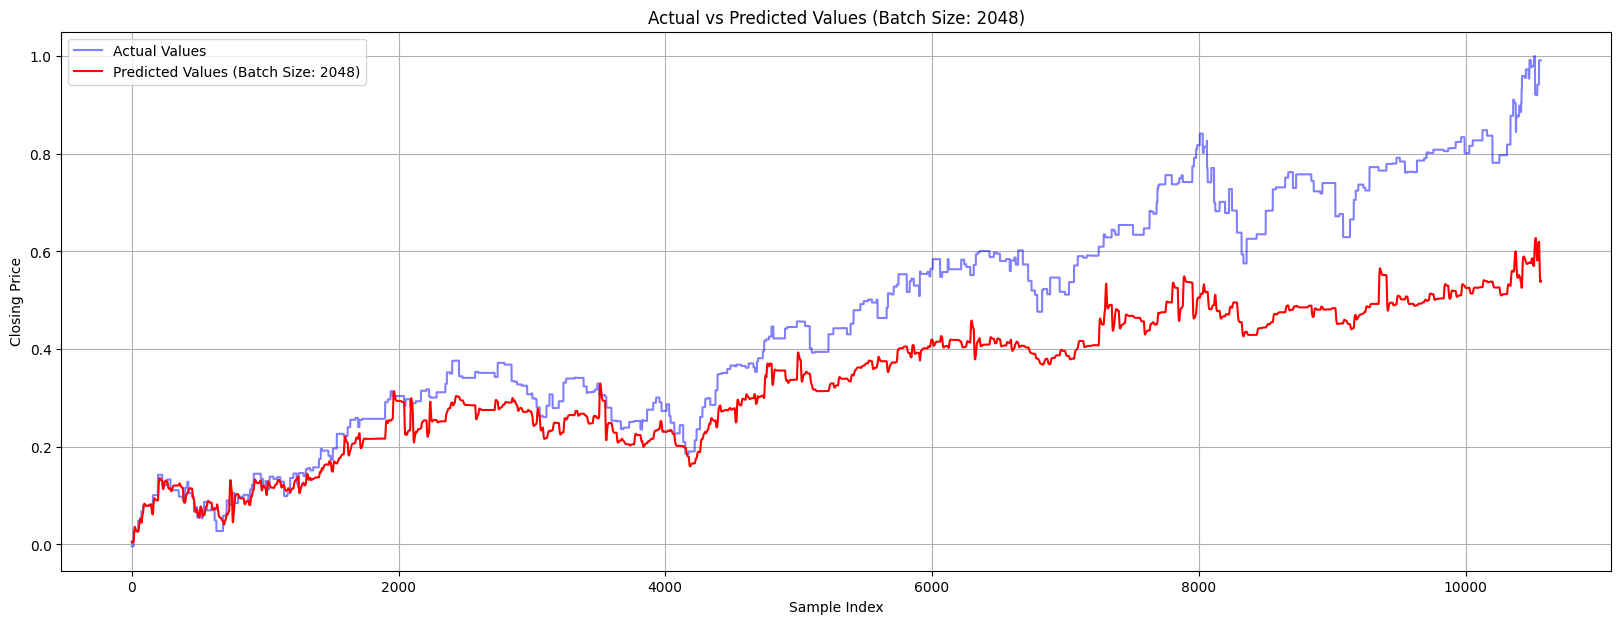

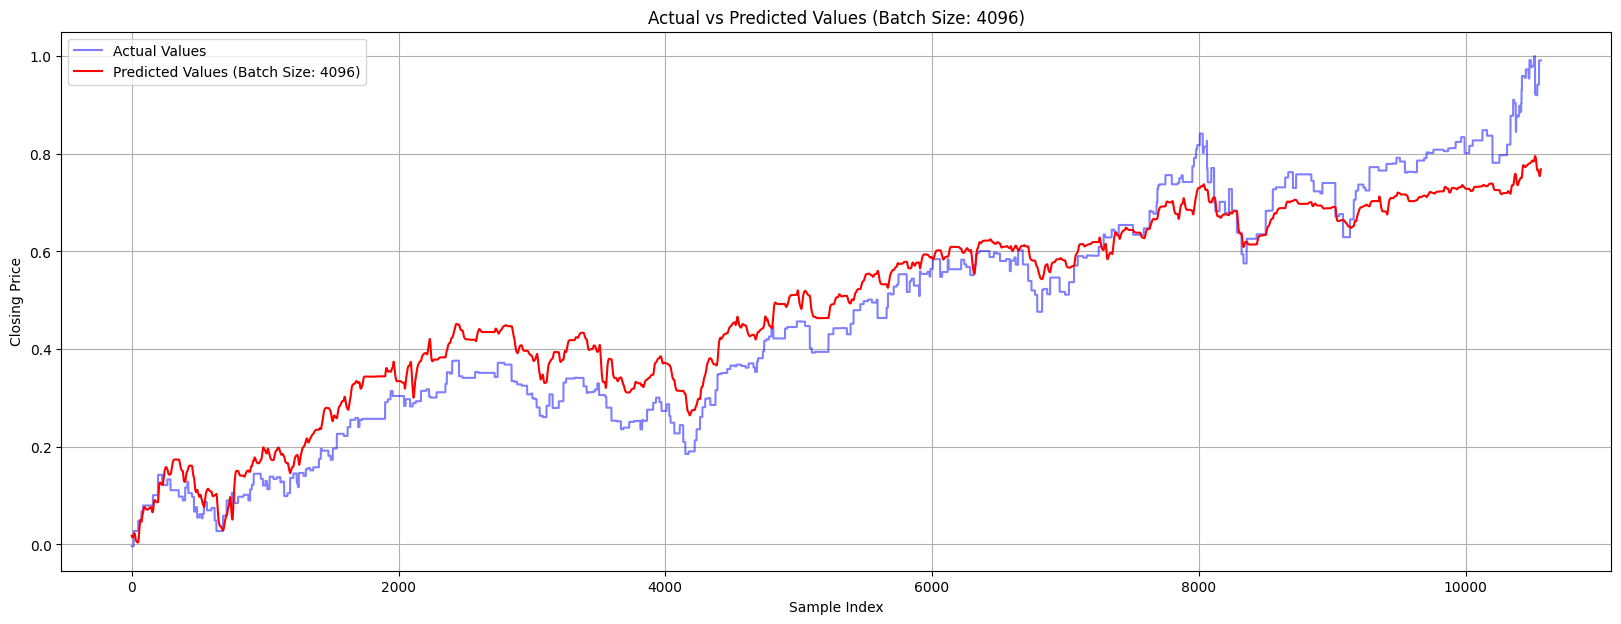

In [34]:
import matplotlib.pyplot as plt

for batch_size in batch_sizes:
    plt.figure(figsize=(20, 7))
    
    # Plot actual values
    plt.plot(y_test.flatten(), label='Actual Values', color='blue', alpha=0.5)
    
    # Plot predicted values
    plt.plot(predictions_dict[batch_size], label=f'Predicted Values (Batch Size: {batch_size})', color='red')
    
    plt.title(f'Actual vs Predicted Values (Batch Size: {batch_size})')
    plt.xlabel('Sample Index')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()

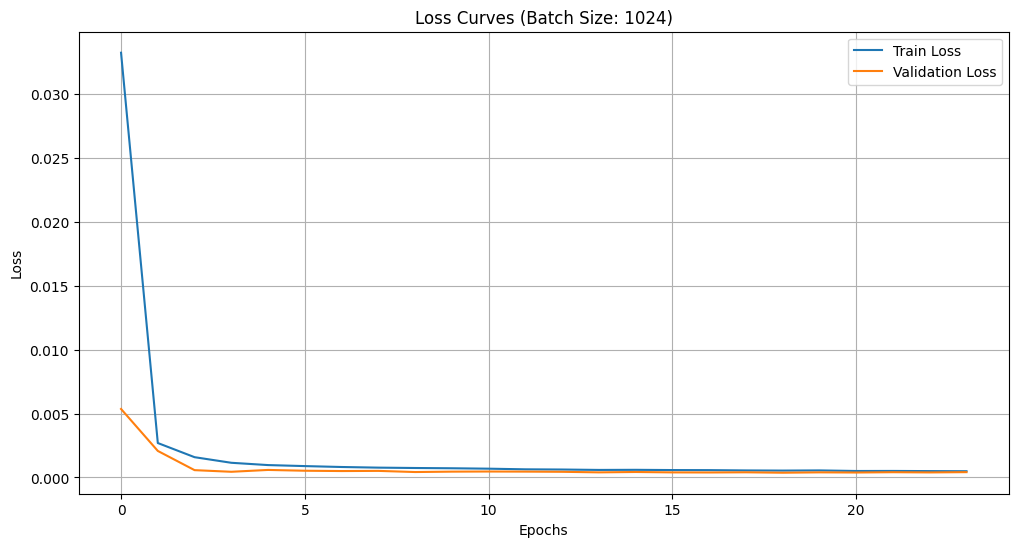

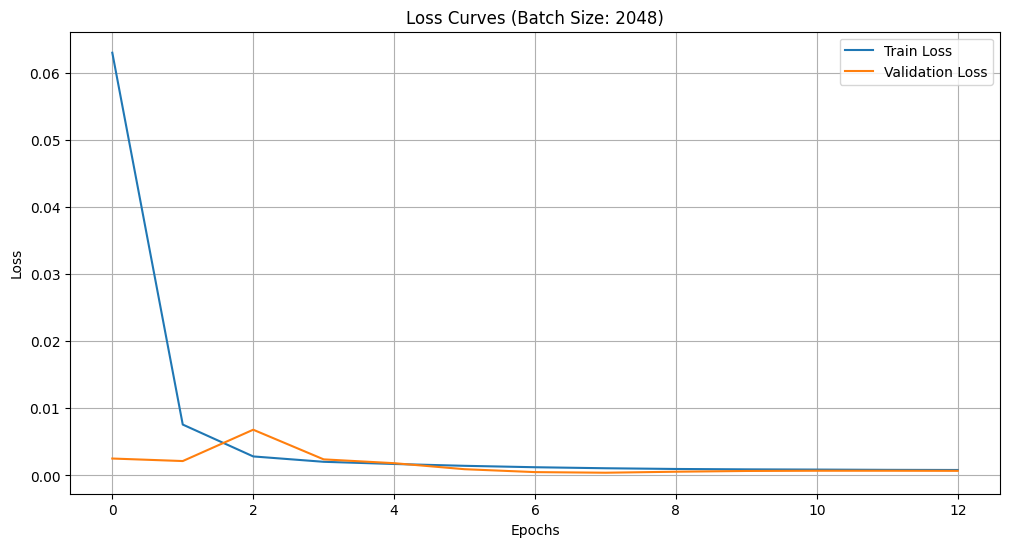

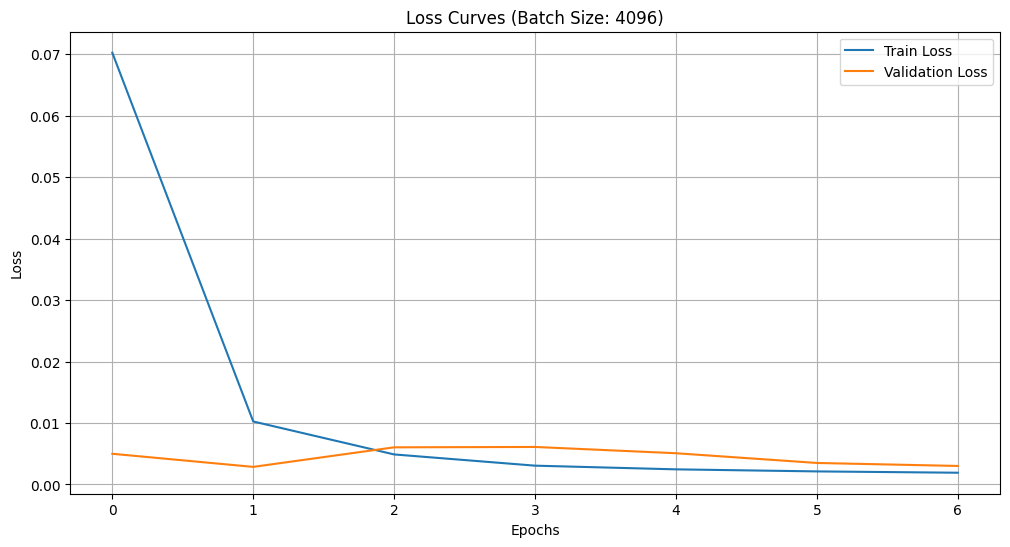

In [35]:
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[batch_size]['loss'], label='Train Loss')
    plt.plot(history_dict[batch_size]['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves (Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()